In [26]:
# Standard packages
import os
import torch
import pickle
import random
import numpy as np
from modules.autoencoder import *
from sklearn.model_selection import KFold

from torch import nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset

In [2]:
# Colab packages
from google.colab import files, drive

# Connect drive to colab
drive.mount('/content/drive')

# Create directories (Colab)
!mkdir ./dataset
!mkdir ./drive/My\ Drive/results
!mkdir ./drive/My\ Drive/results/losses

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data loading and preprocessing

In [27]:
#%% Define paths

data_root_dir = './dataset'


#%% Create dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(data_root_dir, train=True,  download=True, transform=train_transform)
test_dataset  = MNIST(data_root_dir, train=False, download=True, transform=test_transform)

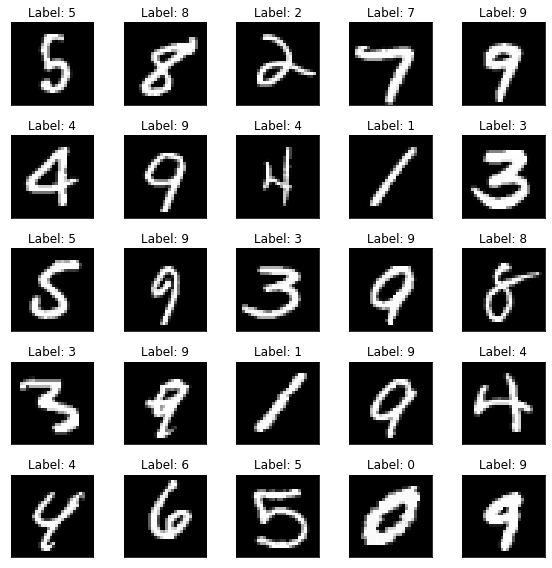

In [28]:
### Plot some sample
plt.close('all')
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(img.squeeze().numpy(), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

## Architecture definition

In [29]:
### Dimension of the batch
batch_size = 1000
### Number of epochs
num_epochs = 20
### Hidden layer dimension - TODO: tuning
encoded_space_dim = 8

### Initialize the network
net = Autoencoder(encoded_space_dim=encoded_space_dim)

In [30]:
### Some examples
# Take an input image (remember to add the batch dimension)
img = test_dataset[0][0].unsqueeze(0)
print('Original image shape:', img.shape)
# Encode the image
img_enc = net.encode(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = net.decode(img_enc)
print('Decoded image shape:', dec_img.shape)

del img, img_enc, dec_img

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 8])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [31]:
#%% Prepare training

### Define dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Define a loss function
loss_fn = torch.nn.MSELoss()

device = torch.device("cpu")
# Move all the network parameters to the selected device (if they are already on that device nothing happens)
print('### ARCHITECTURE ###')
net.to(device)

### ARCHITECTURE ###


Autoencoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvT

## Parameter optimization: GridSearch and CrossValidation

In [ ]:
%%time

indices = list(range(len(train_dataset)))

# learning rate cycle
for lr in [1e-2, 1e-3, 1e-4]:
    # weight decay cycle
    for decay in [1e-3, 1e-4, 1e-5]:
        print(f'### PARAMETERS: lr = {lr}, decay = {decay} ###')
        results = train_CV(indices, device, train_dataset, encoded_dim = encoded_space_dim, 
                                      lr = lr, wd = decay, num_epochs = num_epochs)
        # Save results
        with open(f'./drive/My Drive/results/losses/CV_loss_{encoded_space_dim}_{lr}_{decay}.pickle', 'wb') as f:
            pickle.dump(results, f)

### PARAMETERS: lr = 0.01, decay = 0.001 ###
+++ FOLD 0 +++
EPOCH 1/20
	 TRAINING - EPOCH 1/20 - loss: 0.094654
	 VALIDATION - EPOCH 1/20 - loss: 0.070204

EPOCH 2/20
	 TRAINING - EPOCH 2/20 - loss: 0.068374
	 VALIDATION - EPOCH 2/20 - loss: 0.067588

EPOCH 3/20
	 TRAINING - EPOCH 3/20 - loss: 0.067651
	 VALIDATION - EPOCH 3/20 - loss: 0.067576

EPOCH 4/20
	 TRAINING - EPOCH 4/20 - loss: 0.066437
	 VALIDATION - EPOCH 4/20 - loss: 0.065123

EPOCH 5/20
	 TRAINING - EPOCH 5/20 - loss: 0.064671
	 VALIDATION - EPOCH 5/20 - loss: 0.064055

EPOCH 6/20
	 TRAINING - EPOCH 6/20 - loss: 0.064277
	 VALIDATION - EPOCH 6/20 - loss: 0.064106

EPOCH 7/20
	 TRAINING - EPOCH 7/20 - loss: 0.064209
	 VALIDATION - EPOCH 7/20 - loss: 0.063919

EPOCH 8/20
	 TRAINING - EPOCH 8/20 - loss: 0.064172
	 VALIDATION - EPOCH 8/20 - loss: 0.063878

EPOCH 9/20
	 TRAINING - EPOCH 9/20 - loss: 0.064195
	 VALIDATION - EPOCH 9/20 - loss: 0.063894

EPOCH 10/20
	 TRAINING - EPOCH 10/20 - loss: 0.064065
	 VALIDATION - EPOCH 1

## Results Visualization

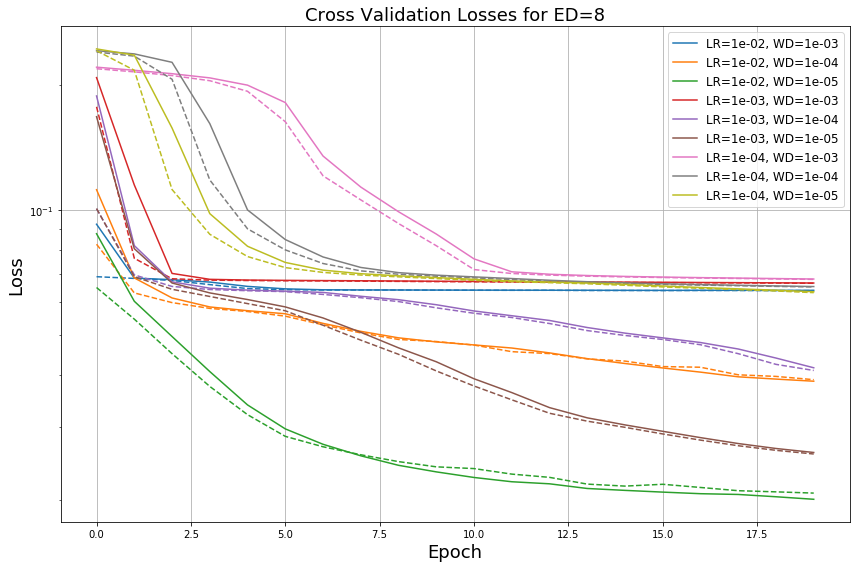

In [24]:
# Set dimension of interest
encoded_space_dim = 8

# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))
cmap = plt.get_cmap("tab10")

i = 0
# learning rate cycle
for lr in [1e-2, 1e-3, 1e-4]:
    # weight decay cycle
    for decay in [1e-3, 1e-4, 1e-5]:
        # retrive data
        with open(f'results/losses/CV_loss_{encoded_space_dim}_{lr}_{decay}.pickle','rb') as f:
            results = pickle.load(f)
        # plot data
        plt.semilogy(results['train loss'], 
                    label='LR={:1.0e}, WD={:1.0e}'.format(lr,decay),
                    color = cmap(i))
        plt.semilogy(results['validation loss'], 
                    #label='Validation loss mean fold LR={:1.0e}, WD={:1.0e}'.format(lr,decay),
                    linestyle='dashed',
                    color = cmap(i))
        i += 1


plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.title(f'Cross Validation Losses for ED={encoded_space_dim}', fontsize=18)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig(f"images/CV_losses_{encoded_space_dim}.png")
#files.download(f"CV_losses_{encoded_space_dim}.png")
plt.show()

## Training with optimized parameters

EPOCH 1/100

	 TRAINING - EPOCH 1/100 - loss: 0.026633

	 VALIDATION - EPOCH 1/100 - loss: 0.017656




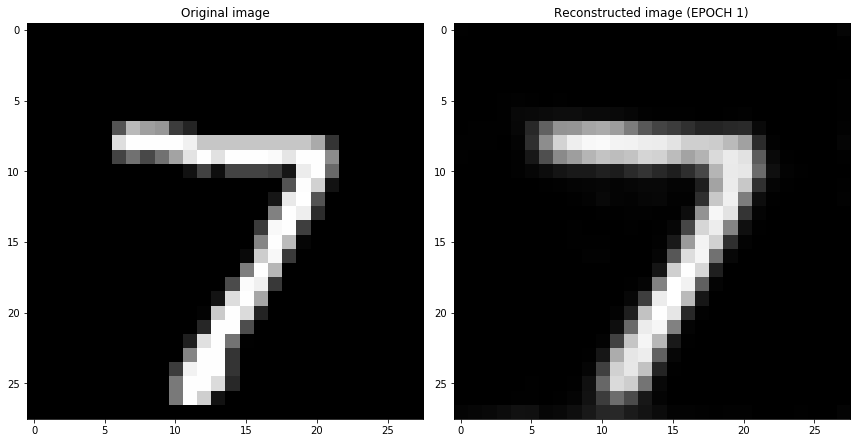

<Figure size 432x288 with 0 Axes>

EPOCH 2/100

	 TRAINING - EPOCH 2/100 - loss: 0.017060

	 VALIDATION - EPOCH 2/100 - loss: 0.016707




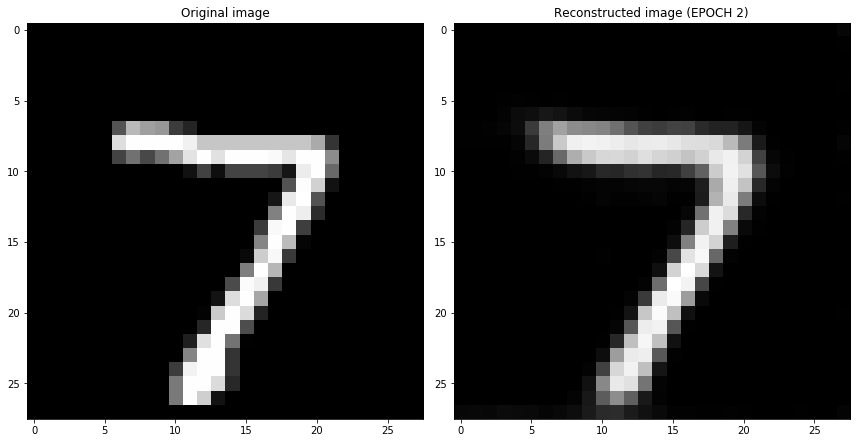

<Figure size 432x288 with 0 Axes>

EPOCH 3/100

	 TRAINING - EPOCH 3/100 - loss: 0.016622

	 VALIDATION - EPOCH 3/100 - loss: 0.016556




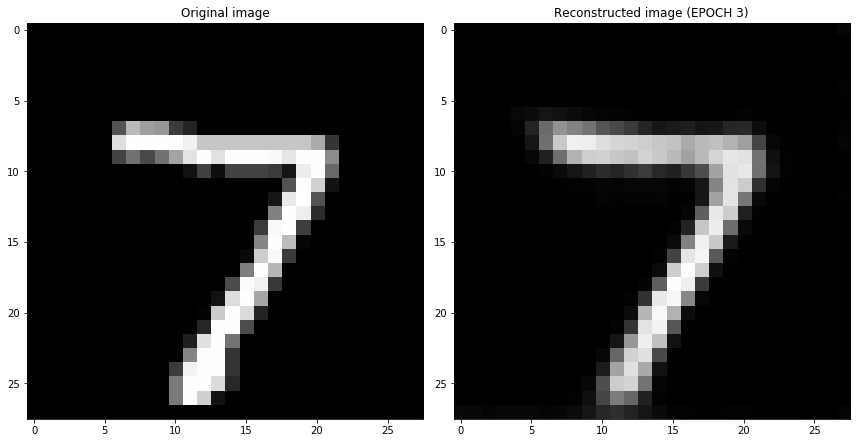

<Figure size 432x288 with 0 Axes>

EPOCH 4/100

	 TRAINING - EPOCH 4/100 - loss: 0.016487

	 VALIDATION - EPOCH 4/100 - loss: 0.016262




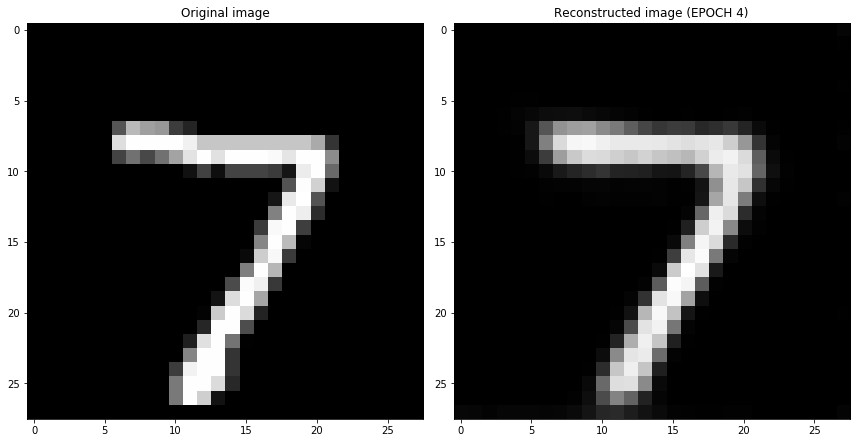

<Figure size 432x288 with 0 Axes>

EPOCH 5/100

	 TRAINING - EPOCH 5/100 - loss: 0.016314

	 VALIDATION - EPOCH 5/100 - loss: 0.016308




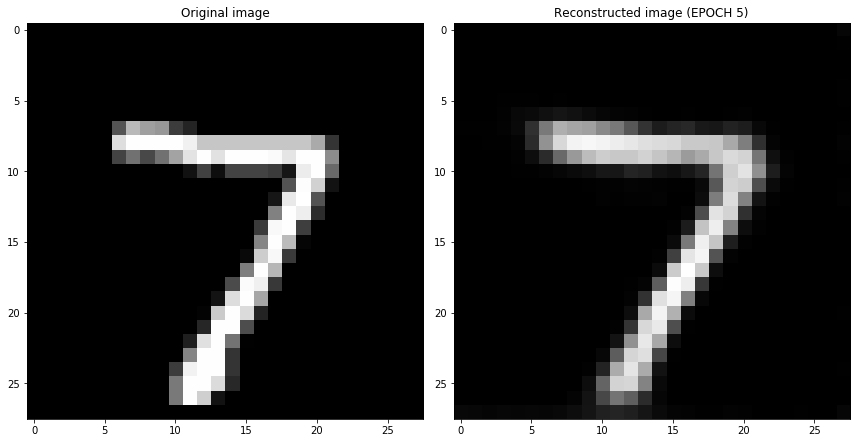

<Figure size 432x288 with 0 Axes>

EPOCH 6/100

	 TRAINING - EPOCH 6/100 - loss: 0.016262

	 VALIDATION - EPOCH 6/100 - loss: 0.016090




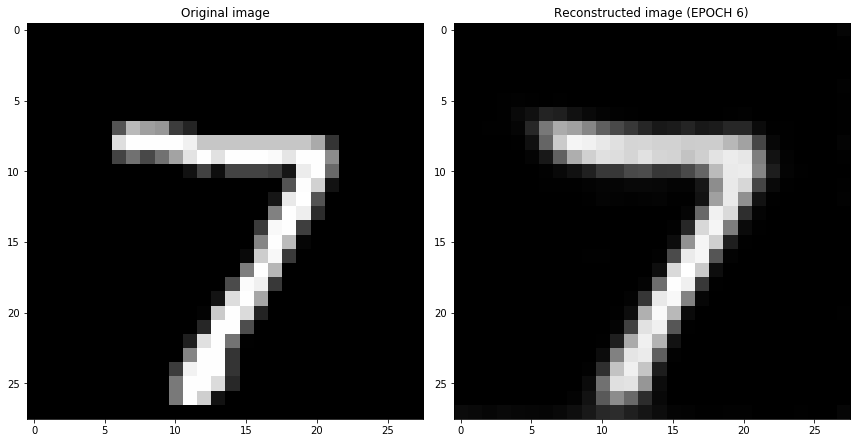

<Figure size 432x288 with 0 Axes>

EPOCH 7/100

	 TRAINING - EPOCH 7/100 - loss: 0.016201

	 VALIDATION - EPOCH 7/100 - loss: 0.015997




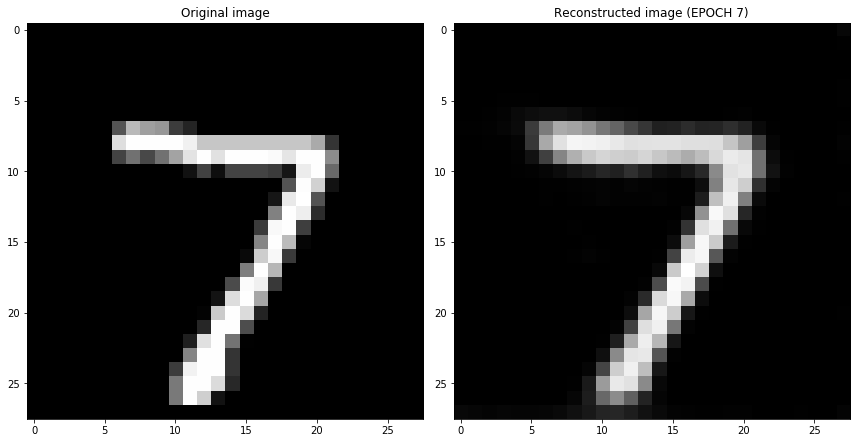

<Figure size 432x288 with 0 Axes>

EPOCH 8/100

	 TRAINING - EPOCH 8/100 - loss: 0.016189

	 VALIDATION - EPOCH 8/100 - loss: 0.016051




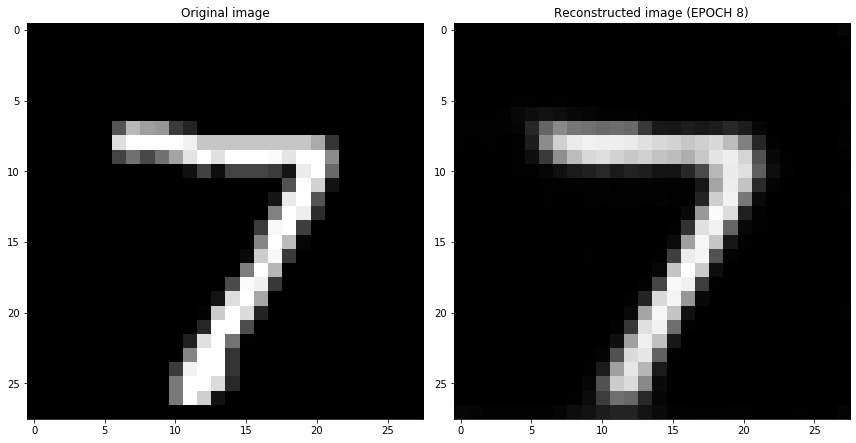

<Figure size 432x288 with 0 Axes>

EPOCH 9/100

	 TRAINING - EPOCH 9/100 - loss: 0.016116

	 VALIDATION - EPOCH 9/100 - loss: 0.016557




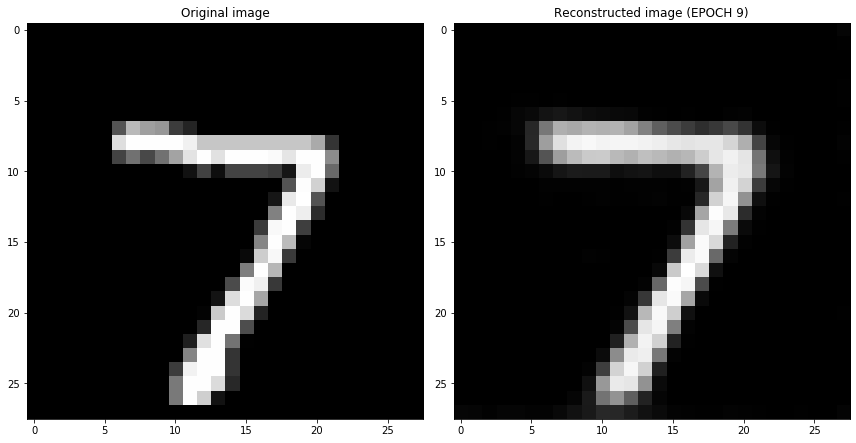

<Figure size 432x288 with 0 Axes>

EPOCH 10/100

	 TRAINING - EPOCH 10/100 - loss: 0.016156

	 VALIDATION - EPOCH 10/100 - loss: 0.016601




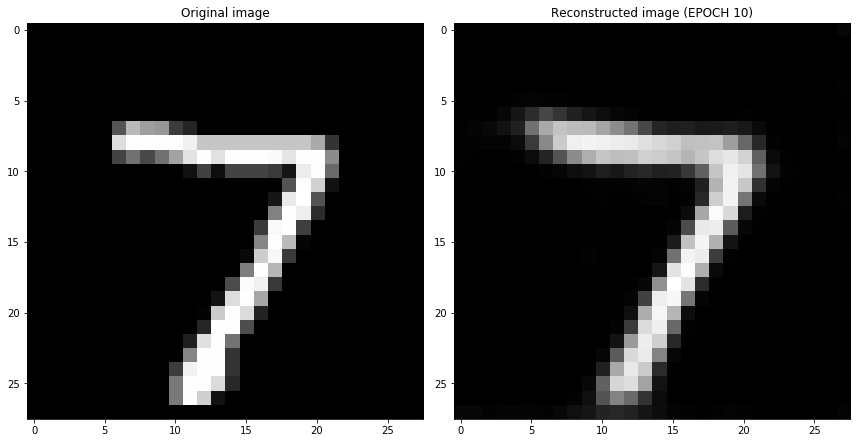

<Figure size 432x288 with 0 Axes>

EPOCH 11/100

	 TRAINING - EPOCH 11/100 - loss: 0.016003

	 VALIDATION - EPOCH 11/100 - loss: 0.015913




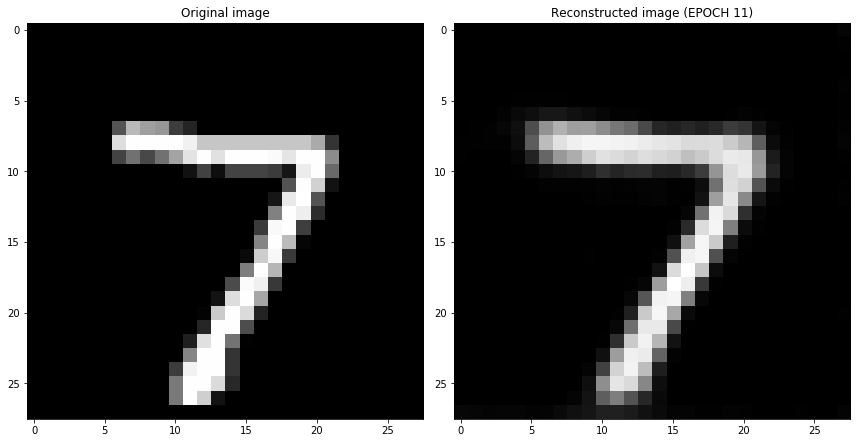

<Figure size 432x288 with 0 Axes>

EPOCH 12/100

	 TRAINING - EPOCH 12/100 - loss: 0.016004

	 VALIDATION - EPOCH 12/100 - loss: 0.015681




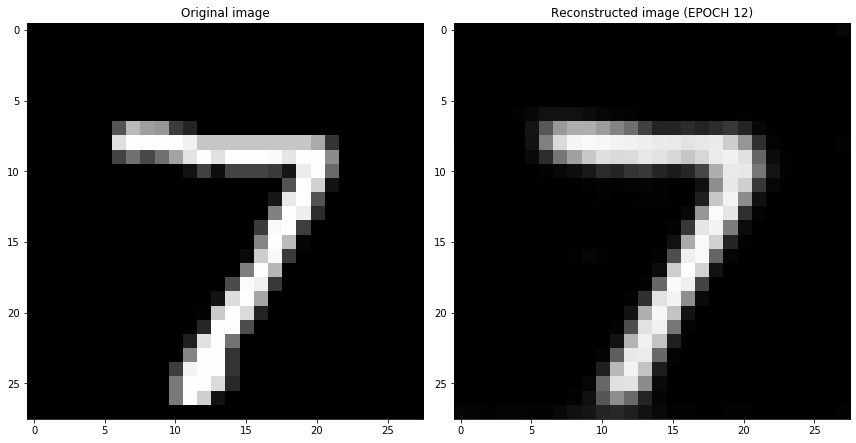

<Figure size 432x288 with 0 Axes>

EPOCH 13/100

	 TRAINING - EPOCH 13/100 - loss: 0.016006

	 VALIDATION - EPOCH 13/100 - loss: 0.015995




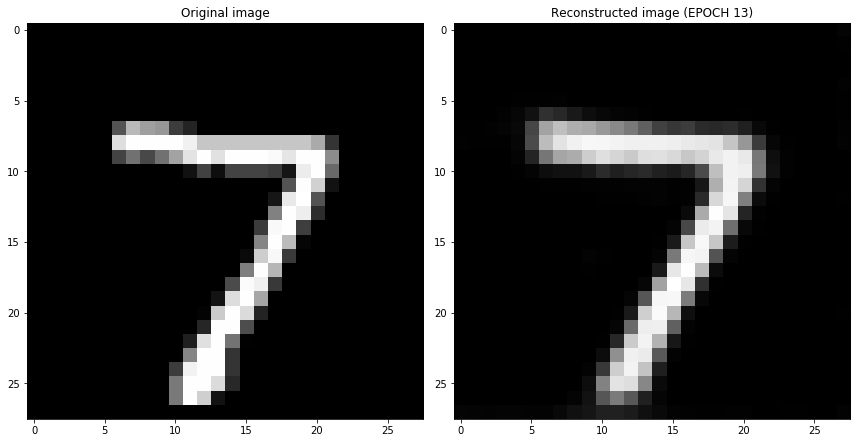

<Figure size 432x288 with 0 Axes>

EPOCH 14/100

	 TRAINING - EPOCH 14/100 - loss: 0.015959

	 VALIDATION - EPOCH 14/100 - loss: 0.015782




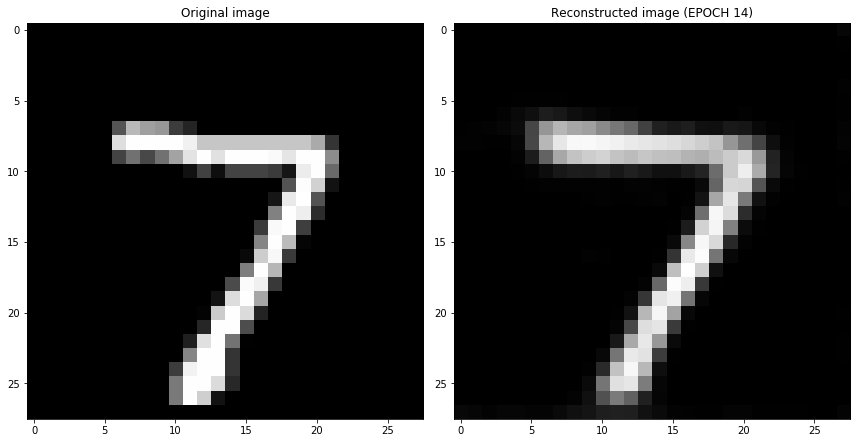

<Figure size 432x288 with 0 Axes>

EPOCH 15/100

	 TRAINING - EPOCH 15/100 - loss: 0.015953

	 VALIDATION - EPOCH 15/100 - loss: 0.015837




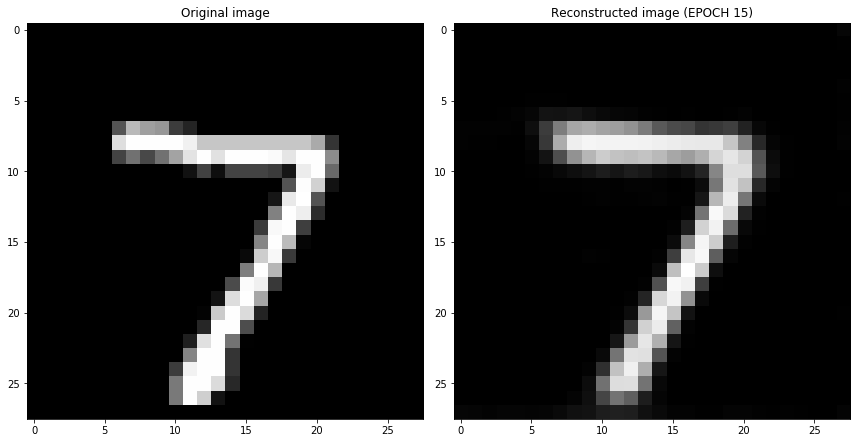

<Figure size 432x288 with 0 Axes>

EPOCH 16/100

	 TRAINING - EPOCH 16/100 - loss: 0.015817

	 VALIDATION - EPOCH 16/100 - loss: 0.015659




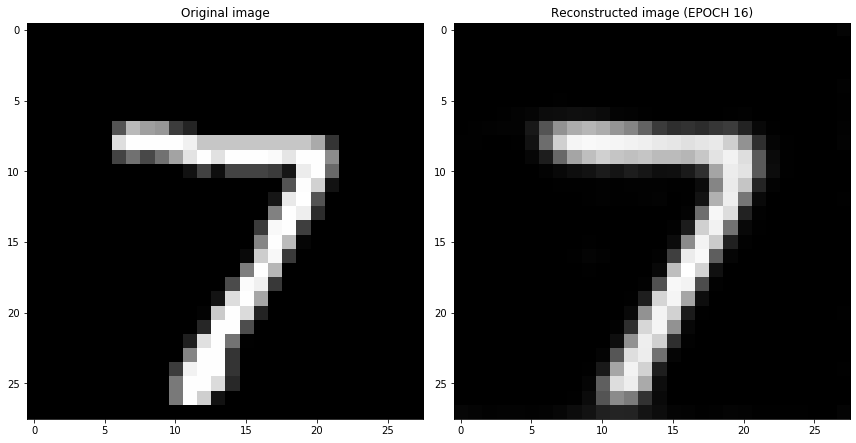

<Figure size 432x288 with 0 Axes>

EPOCH 17/100

	 TRAINING - EPOCH 17/100 - loss: 0.015918

	 VALIDATION - EPOCH 17/100 - loss: 0.015609




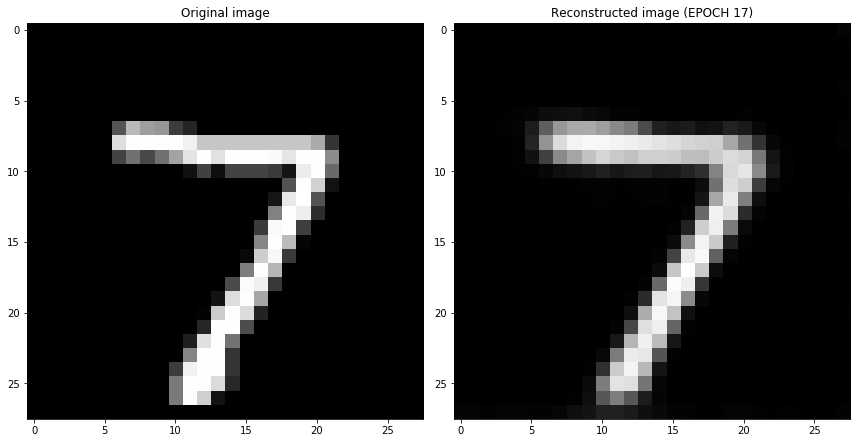

<Figure size 432x288 with 0 Axes>

EPOCH 18/100

	 TRAINING - EPOCH 18/100 - loss: 0.015792

	 VALIDATION - EPOCH 18/100 - loss: 0.015584




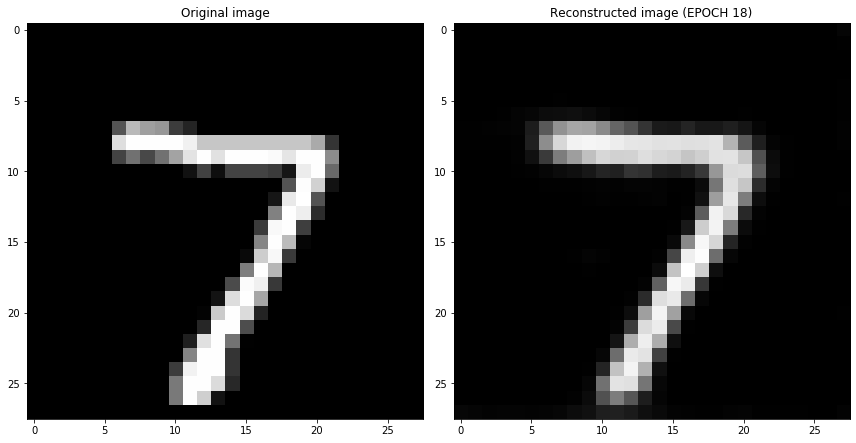

<Figure size 432x288 with 0 Axes>

EPOCH 19/100

	 TRAINING - EPOCH 19/100 - loss: 0.015846

	 VALIDATION - EPOCH 19/100 - loss: 0.015830




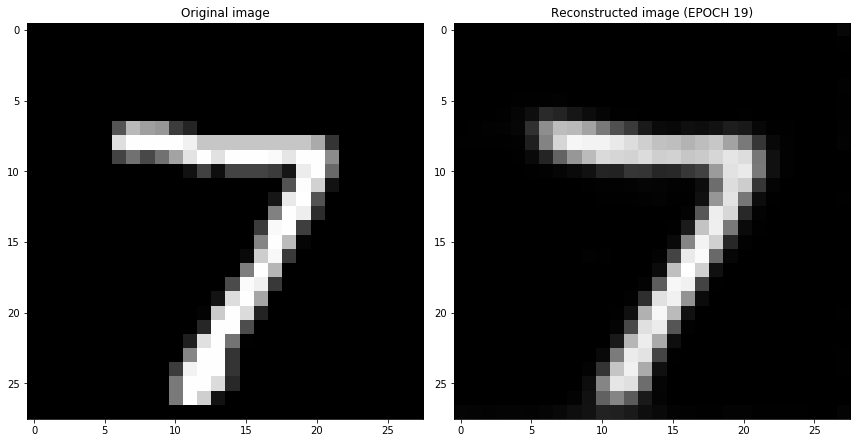

<Figure size 432x288 with 0 Axes>

EPOCH 20/100

	 TRAINING - EPOCH 20/100 - loss: 0.015887

	 VALIDATION - EPOCH 20/100 - loss: 0.015572




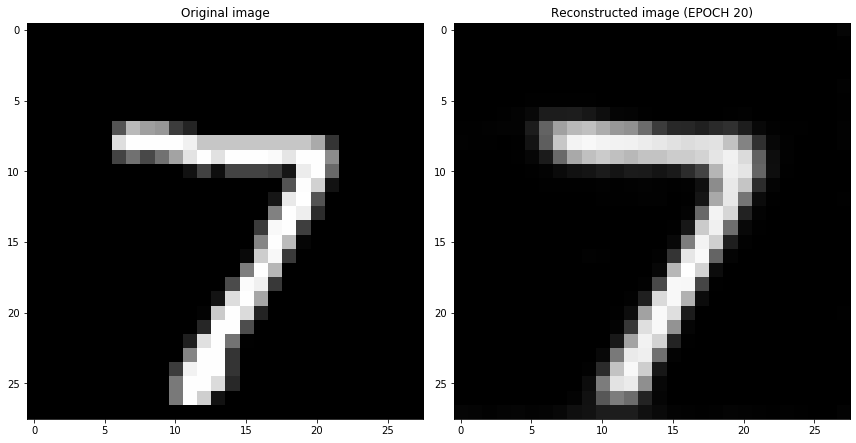

<Figure size 432x288 with 0 Axes>

EPOCH 21/100

	 TRAINING - EPOCH 21/100 - loss: 0.015890

	 VALIDATION - EPOCH 21/100 - loss: 0.015639




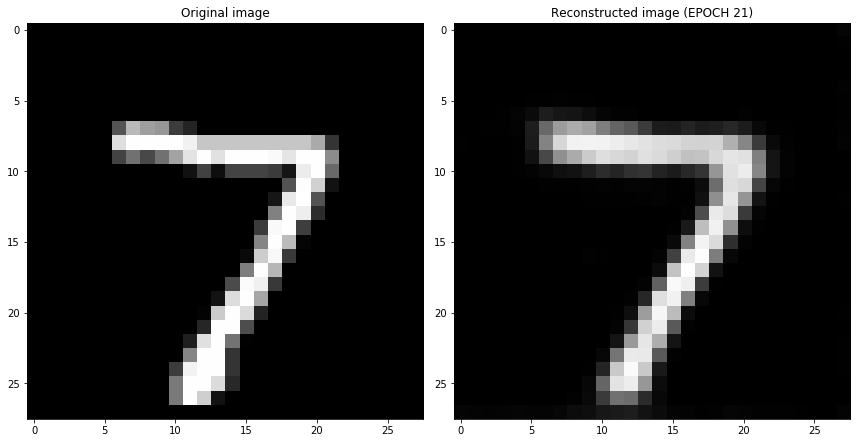

<Figure size 432x288 with 0 Axes>

EPOCH 22/100

	 TRAINING - EPOCH 22/100 - loss: 0.015695

	 VALIDATION - EPOCH 22/100 - loss: 0.015739




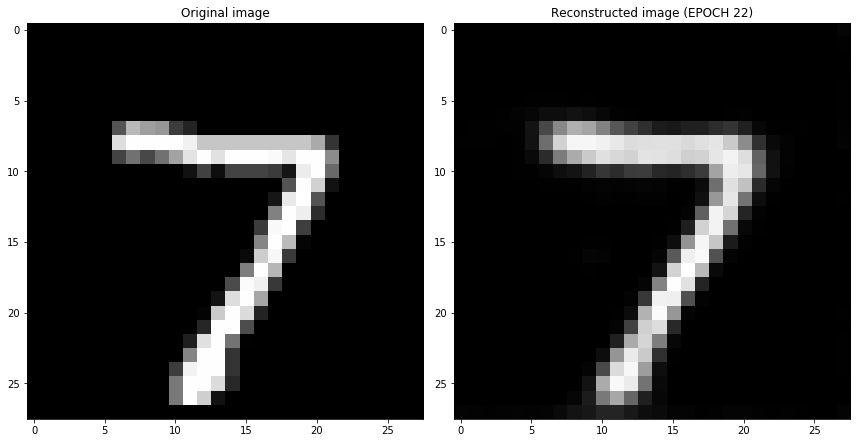

<Figure size 432x288 with 0 Axes>

EPOCH 23/100

	 TRAINING - EPOCH 23/100 - loss: 0.015754

	 VALIDATION - EPOCH 23/100 - loss: 0.015656




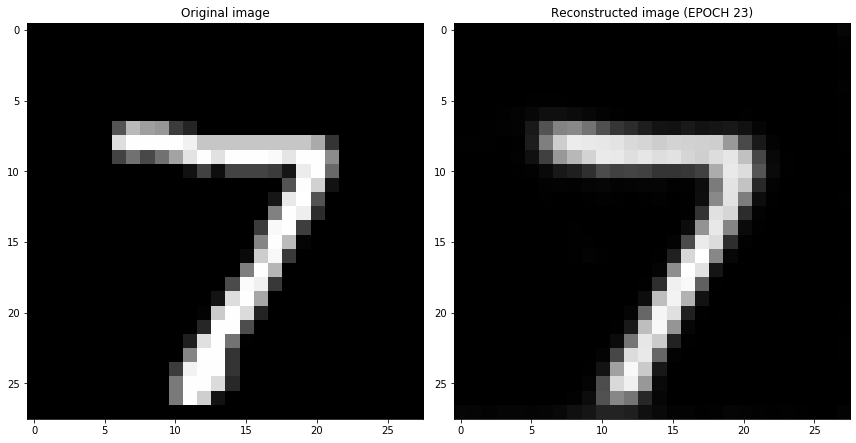

<Figure size 432x288 with 0 Axes>

EPOCH 24/100

	 TRAINING - EPOCH 24/100 - loss: 0.015708

	 VALIDATION - EPOCH 24/100 - loss: 0.015828




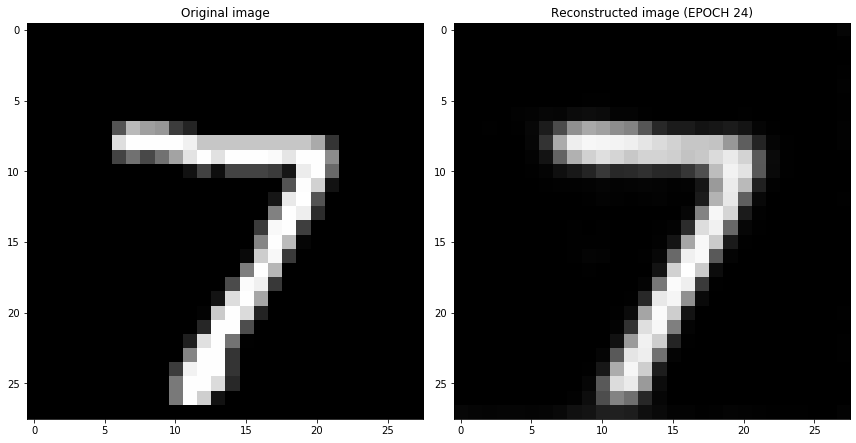

<Figure size 432x288 with 0 Axes>

EPOCH 25/100

	 TRAINING - EPOCH 25/100 - loss: 0.015864

	 VALIDATION - EPOCH 25/100 - loss: 0.015641




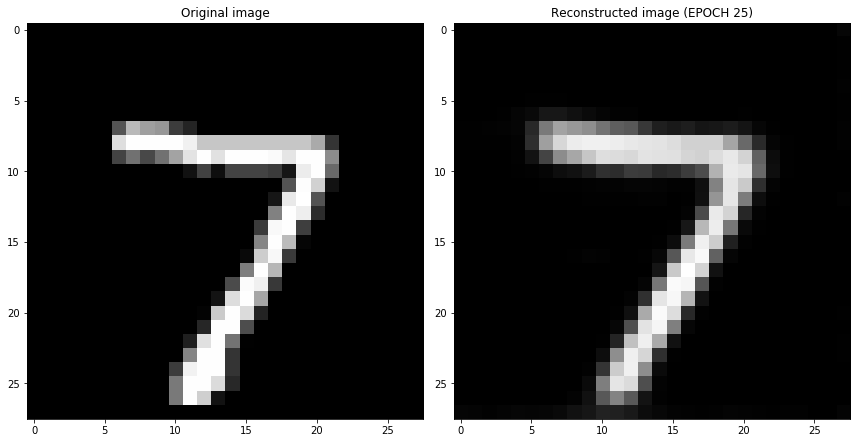

<Figure size 432x288 with 0 Axes>

EPOCH 26/100

	 TRAINING - EPOCH 26/100 - loss: 0.015643

	 VALIDATION - EPOCH 26/100 - loss: 0.015581




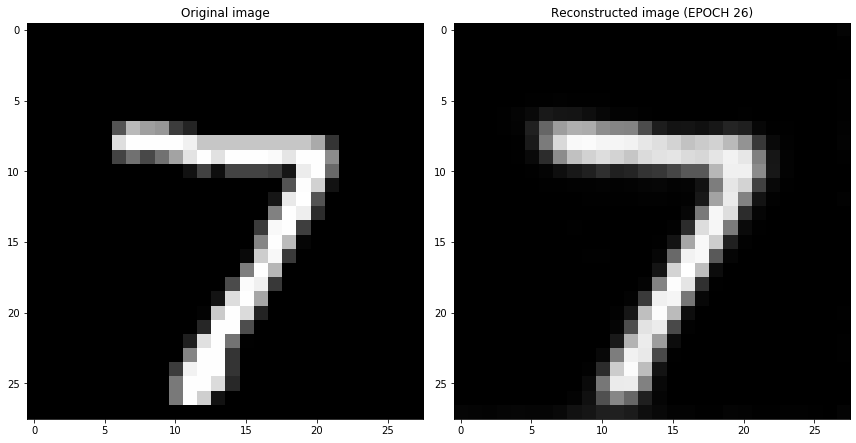

<Figure size 432x288 with 0 Axes>

EPOCH 27/100

	 TRAINING - EPOCH 27/100 - loss: 0.015729

	 VALIDATION - EPOCH 27/100 - loss: 0.015529




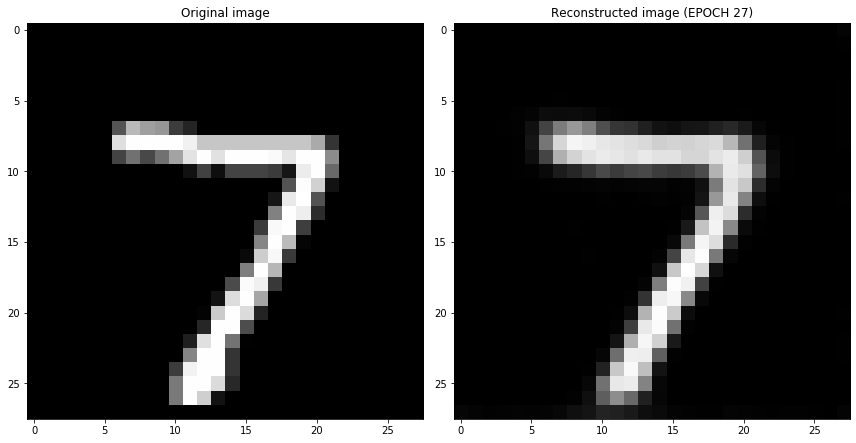

<Figure size 432x288 with 0 Axes>

EPOCH 28/100

	 TRAINING - EPOCH 28/100 - loss: 0.015692

	 VALIDATION - EPOCH 28/100 - loss: 0.015633




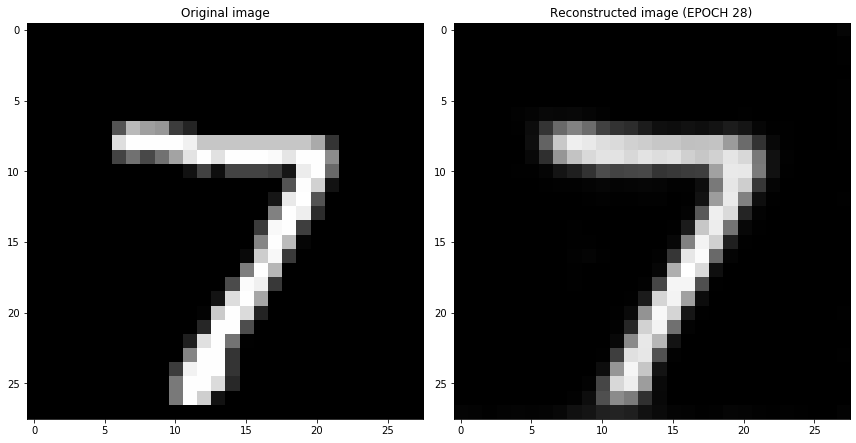

<Figure size 432x288 with 0 Axes>

EPOCH 29/100

	 TRAINING - EPOCH 29/100 - loss: 0.015581

	 VALIDATION - EPOCH 29/100 - loss: 0.015470




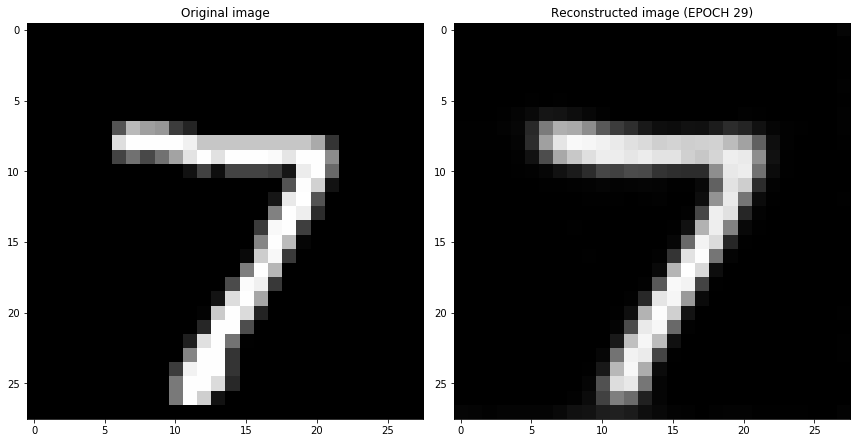

<Figure size 432x288 with 0 Axes>

EPOCH 30/100

	 TRAINING - EPOCH 30/100 - loss: 0.015754

	 VALIDATION - EPOCH 30/100 - loss: 0.015686




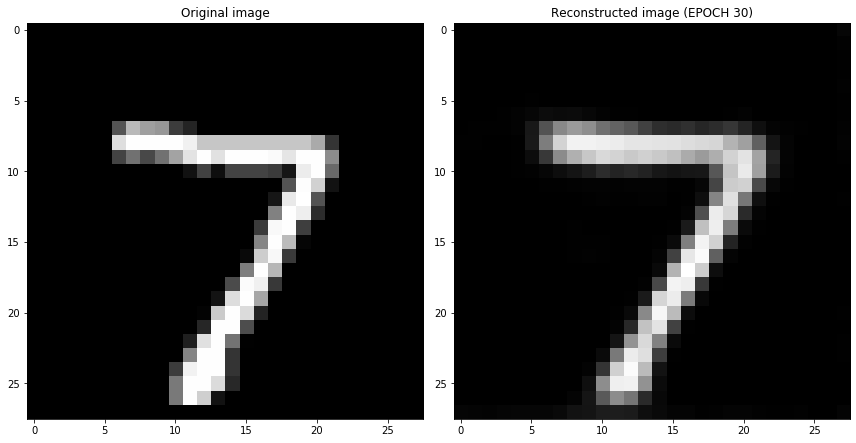

<Figure size 432x288 with 0 Axes>

EPOCH 31/100

	 TRAINING - EPOCH 31/100 - loss: 0.015585

	 VALIDATION - EPOCH 31/100 - loss: 0.015274




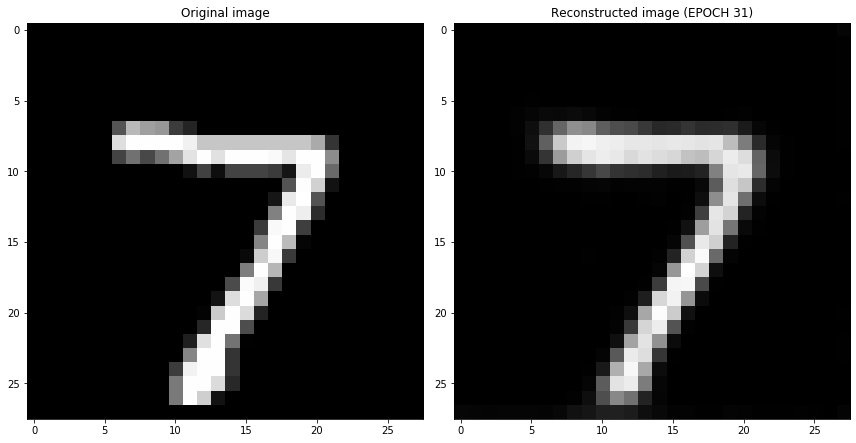

<Figure size 432x288 with 0 Axes>

EPOCH 32/100

	 TRAINING - EPOCH 32/100 - loss: 0.015666

	 VALIDATION - EPOCH 32/100 - loss: 0.015543




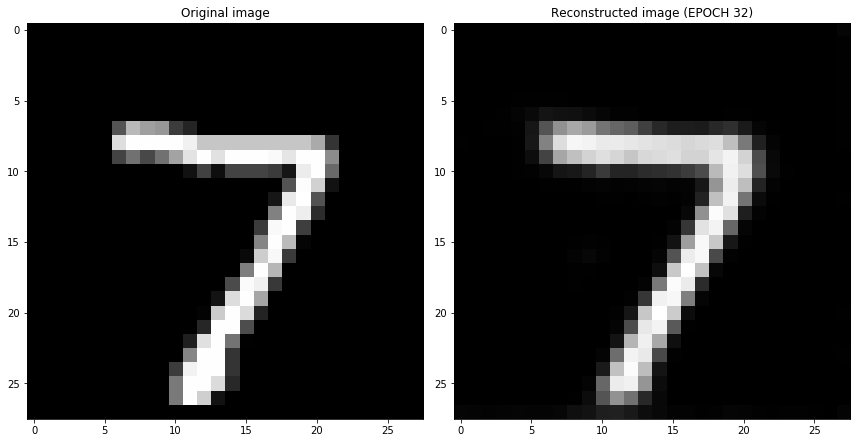

<Figure size 432x288 with 0 Axes>

EPOCH 33/100

	 TRAINING - EPOCH 33/100 - loss: 0.015693

	 VALIDATION - EPOCH 33/100 - loss: 0.015454




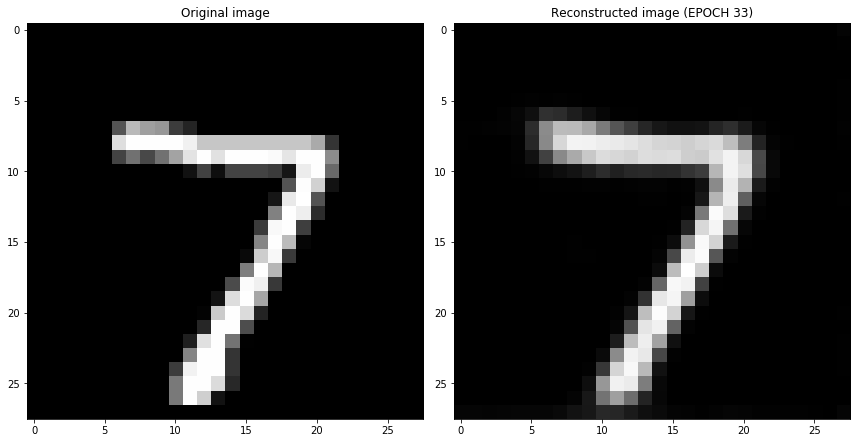

<Figure size 432x288 with 0 Axes>

EPOCH 34/100

	 TRAINING - EPOCH 34/100 - loss: 0.015546

	 VALIDATION - EPOCH 34/100 - loss: 0.015630




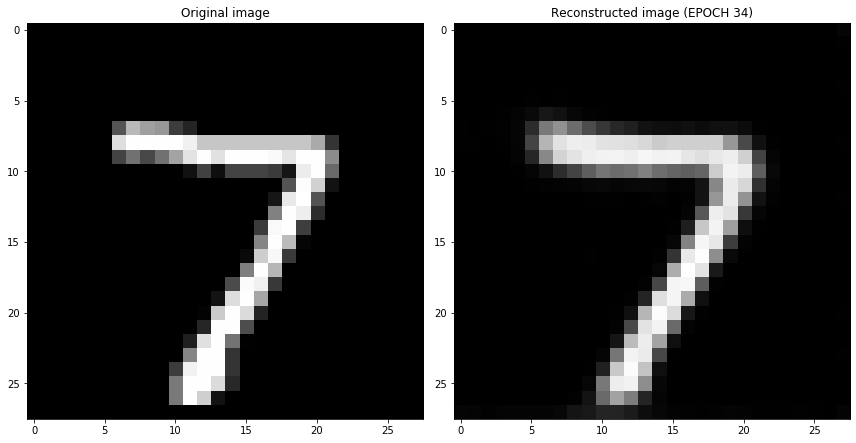

<Figure size 432x288 with 0 Axes>

EPOCH 35/100

	 TRAINING - EPOCH 35/100 - loss: 0.015450

	 VALIDATION - EPOCH 35/100 - loss: 0.015382




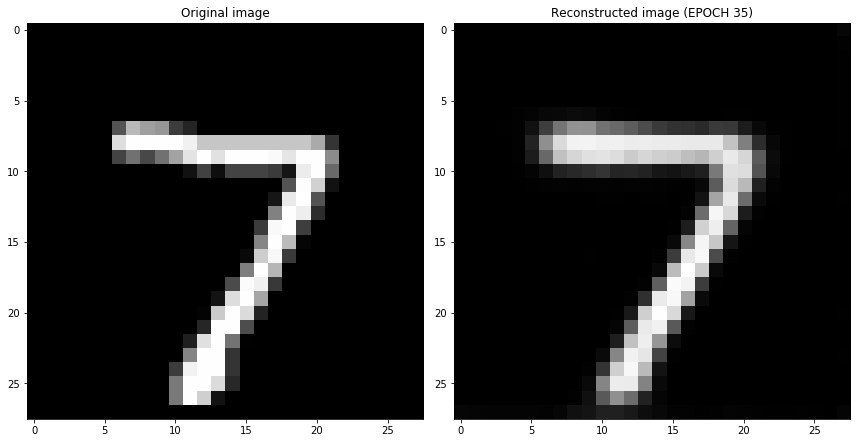

<Figure size 432x288 with 0 Axes>

EPOCH 36/100

	 TRAINING - EPOCH 36/100 - loss: 0.015672

	 VALIDATION - EPOCH 36/100 - loss: 0.015406




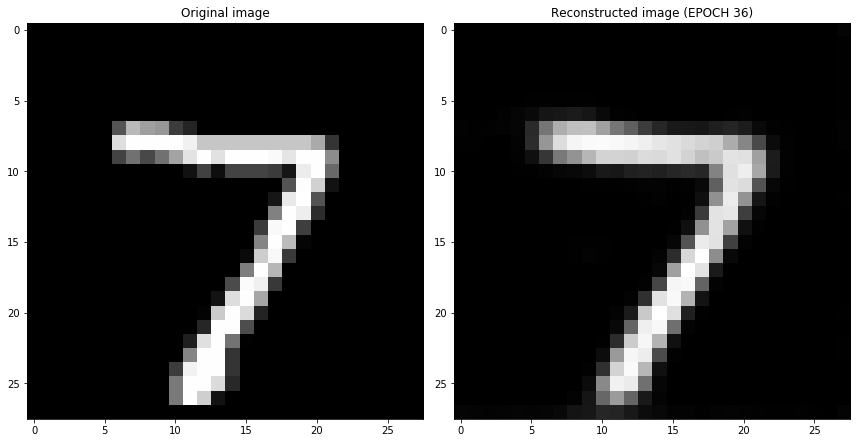

<Figure size 432x288 with 0 Axes>

EPOCH 37/100

	 TRAINING - EPOCH 37/100 - loss: 0.015560

	 VALIDATION - EPOCH 37/100 - loss: 0.015558




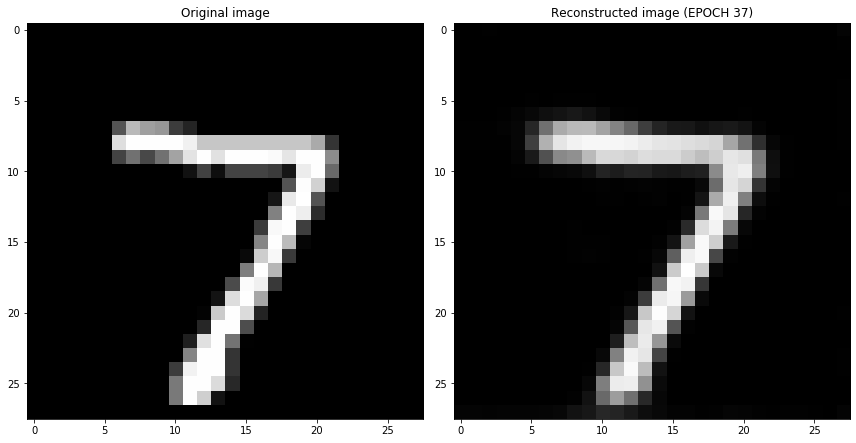

<Figure size 432x288 with 0 Axes>

EPOCH 38/100

	 TRAINING - EPOCH 38/100 - loss: 0.015543

	 VALIDATION - EPOCH 38/100 - loss: 0.015762




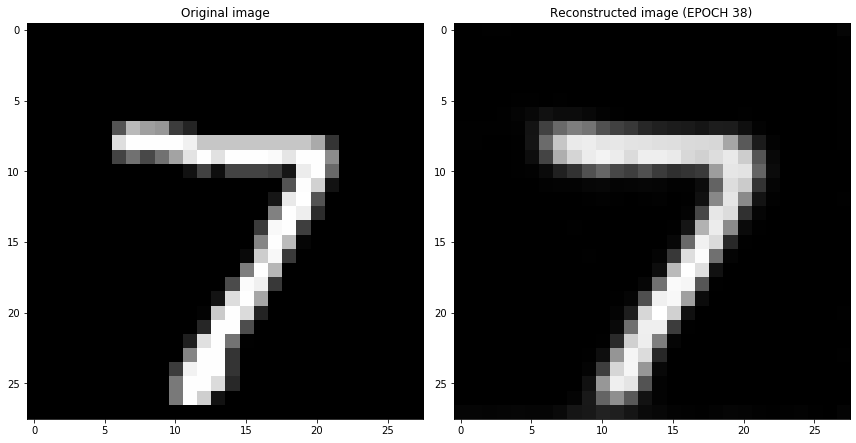

<Figure size 432x288 with 0 Axes>

EPOCH 39/100

	 TRAINING - EPOCH 39/100 - loss: 0.015502

	 VALIDATION - EPOCH 39/100 - loss: 0.015344




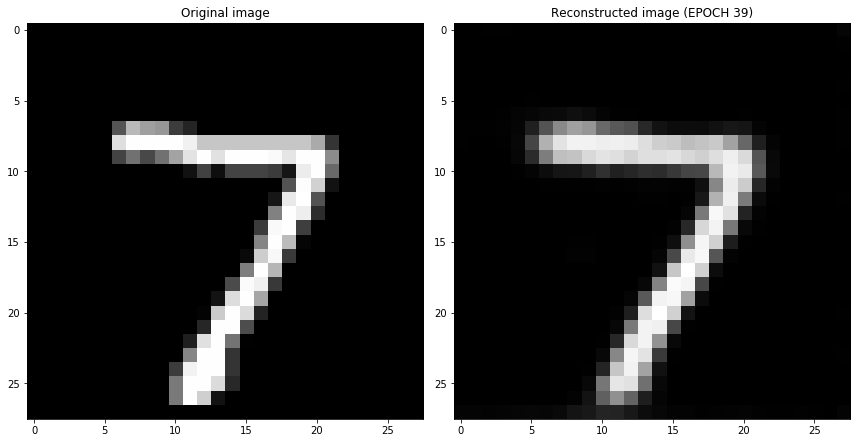

<Figure size 432x288 with 0 Axes>

EPOCH 40/100

	 TRAINING - EPOCH 40/100 - loss: 0.015464

	 VALIDATION - EPOCH 40/100 - loss: 0.015321




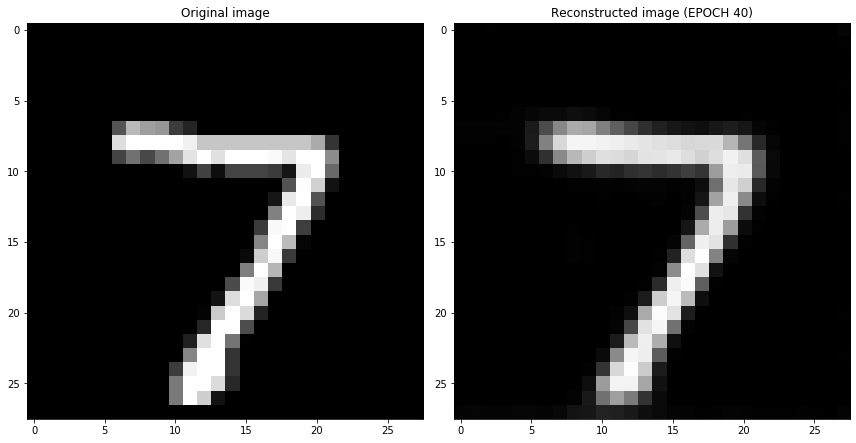

<Figure size 432x288 with 0 Axes>

EPOCH 41/100

	 TRAINING - EPOCH 41/100 - loss: 0.015557

	 VALIDATION - EPOCH 41/100 - loss: 0.015434




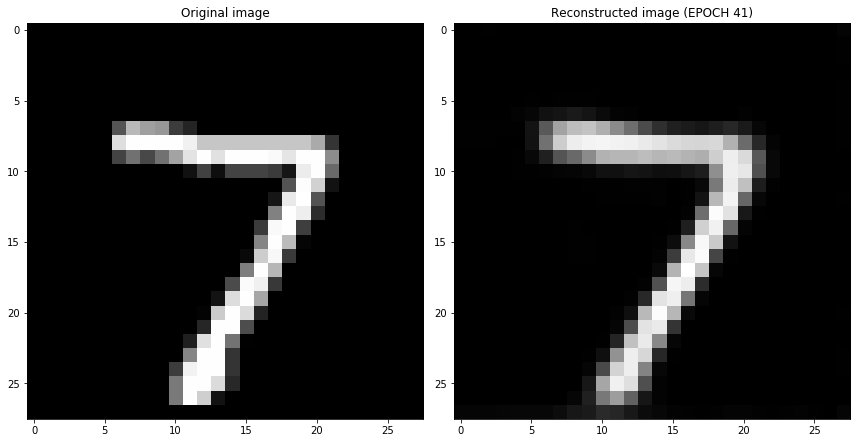

<Figure size 432x288 with 0 Axes>

EPOCH 42/100

	 TRAINING - EPOCH 42/100 - loss: 0.015432

	 VALIDATION - EPOCH 42/100 - loss: 0.015243




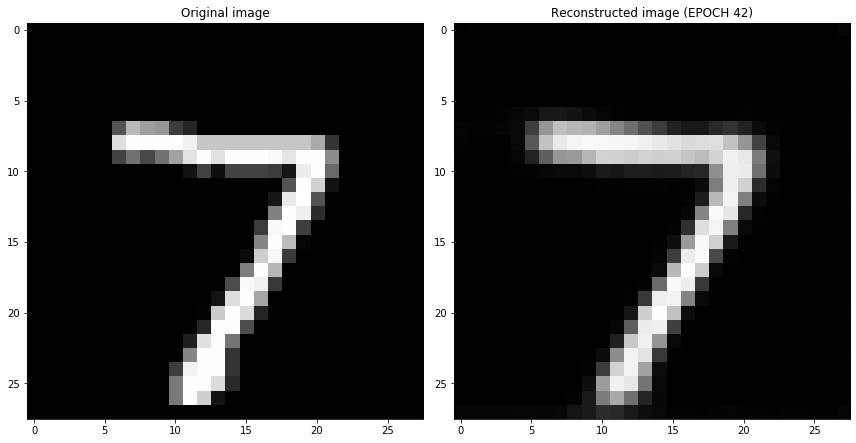

<Figure size 432x288 with 0 Axes>

EPOCH 43/100

	 TRAINING - EPOCH 43/100 - loss: 0.015529

	 VALIDATION - EPOCH 43/100 - loss: 0.015738




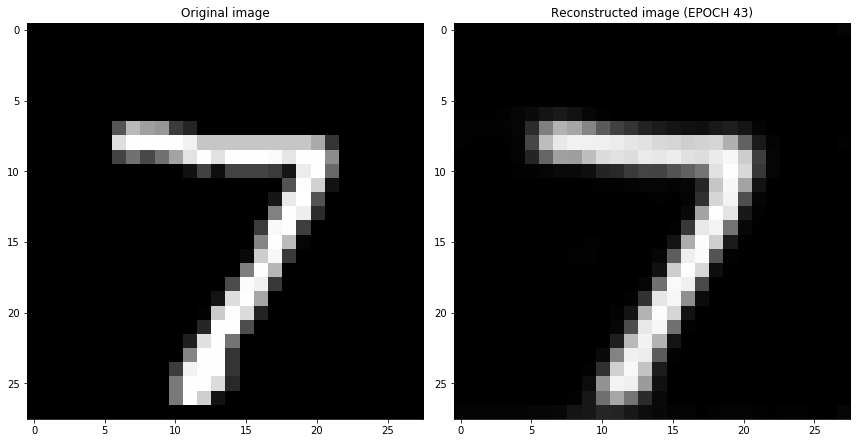

<Figure size 432x288 with 0 Axes>

EPOCH 44/100

	 TRAINING - EPOCH 44/100 - loss: 0.015507

	 VALIDATION - EPOCH 44/100 - loss: 0.015300




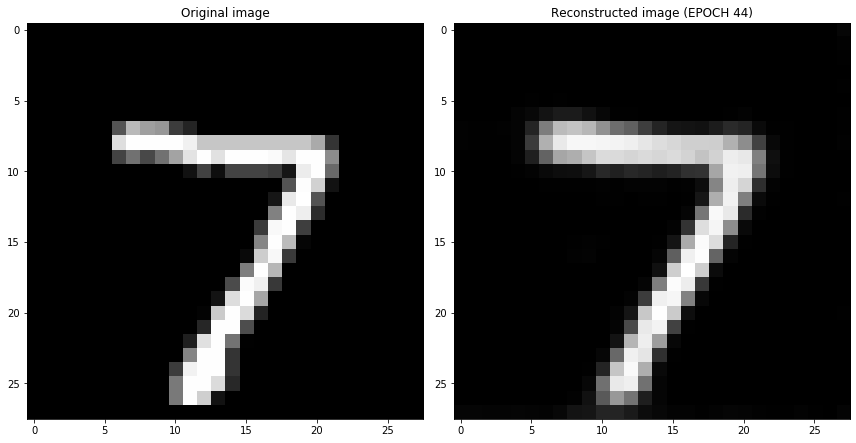

<Figure size 432x288 with 0 Axes>

EPOCH 45/100

	 TRAINING - EPOCH 45/100 - loss: 0.015475

	 VALIDATION - EPOCH 45/100 - loss: 0.015446




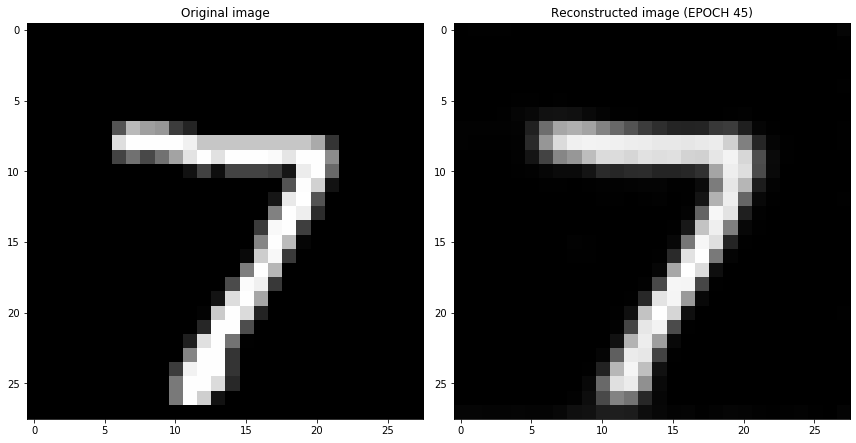

<Figure size 432x288 with 0 Axes>

EPOCH 46/100

	 TRAINING - EPOCH 46/100 - loss: 0.015458

	 VALIDATION - EPOCH 46/100 - loss: 0.015219




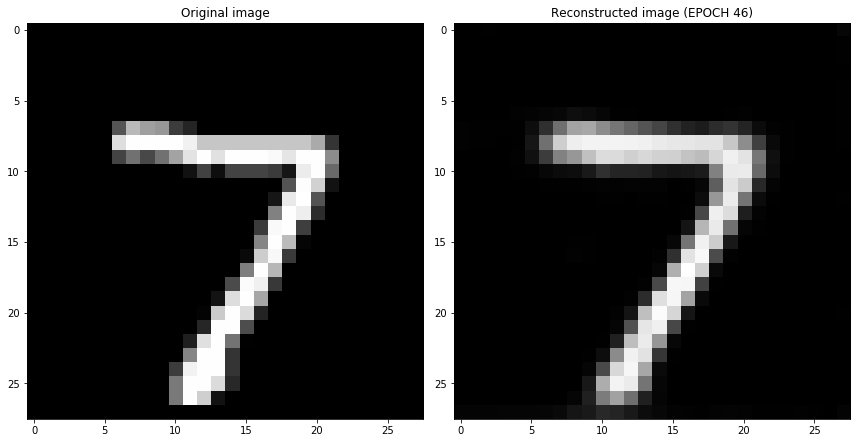

<Figure size 432x288 with 0 Axes>

EPOCH 47/100

	 TRAINING - EPOCH 47/100 - loss: 0.015474

	 VALIDATION - EPOCH 47/100 - loss: 0.015239




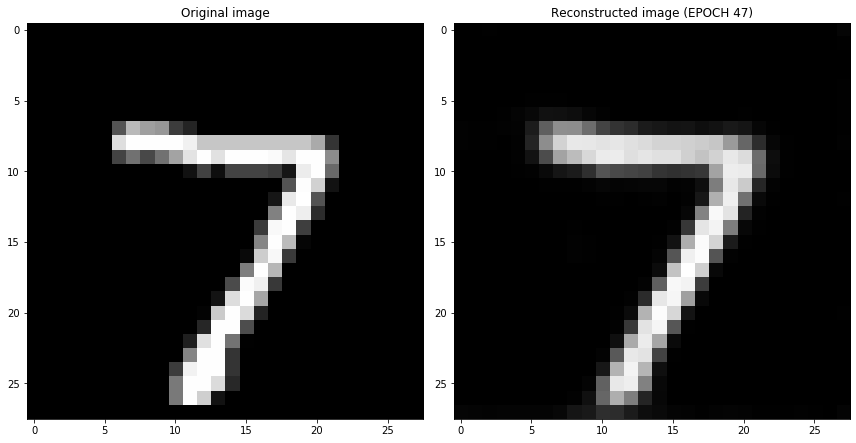

<Figure size 432x288 with 0 Axes>

EPOCH 48/100

	 TRAINING - EPOCH 48/100 - loss: 0.015368

	 VALIDATION - EPOCH 48/100 - loss: 0.016118




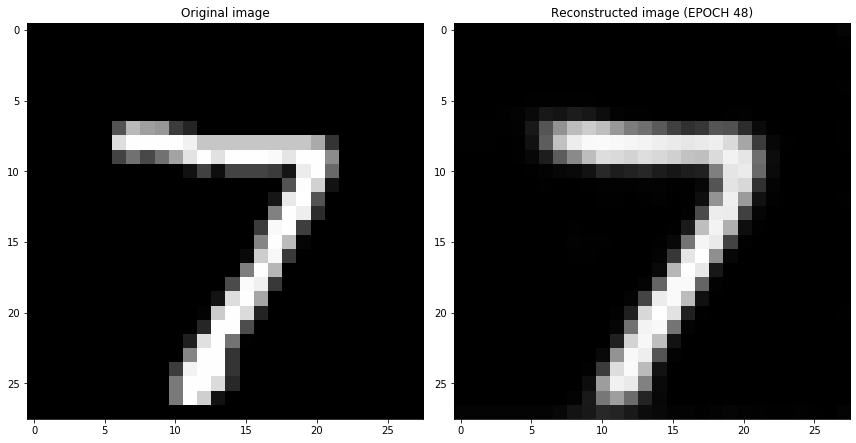

<Figure size 432x288 with 0 Axes>

EPOCH 49/100

	 TRAINING - EPOCH 49/100 - loss: 0.015536

	 VALIDATION - EPOCH 49/100 - loss: 0.015573




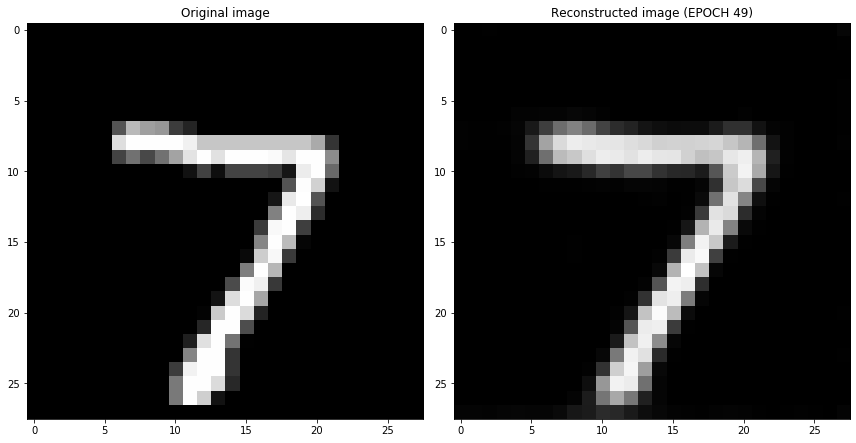

<Figure size 432x288 with 0 Axes>

EPOCH 50/100

	 TRAINING - EPOCH 50/100 - loss: 0.015545

	 VALIDATION - EPOCH 50/100 - loss: 0.015358




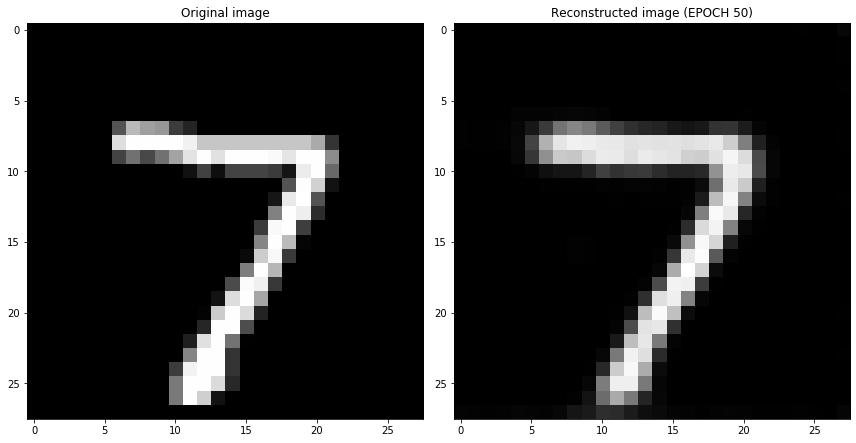

<Figure size 432x288 with 0 Axes>

EPOCH 51/100

	 TRAINING - EPOCH 51/100 - loss: 0.015470

	 VALIDATION - EPOCH 51/100 - loss: 0.015464




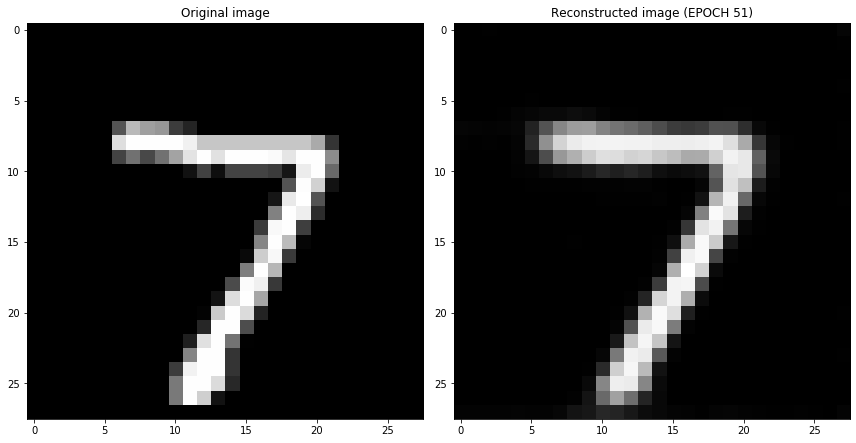

<Figure size 432x288 with 0 Axes>

EPOCH 52/100

	 TRAINING - EPOCH 52/100 - loss: 0.015322

	 VALIDATION - EPOCH 52/100 - loss: 0.015333




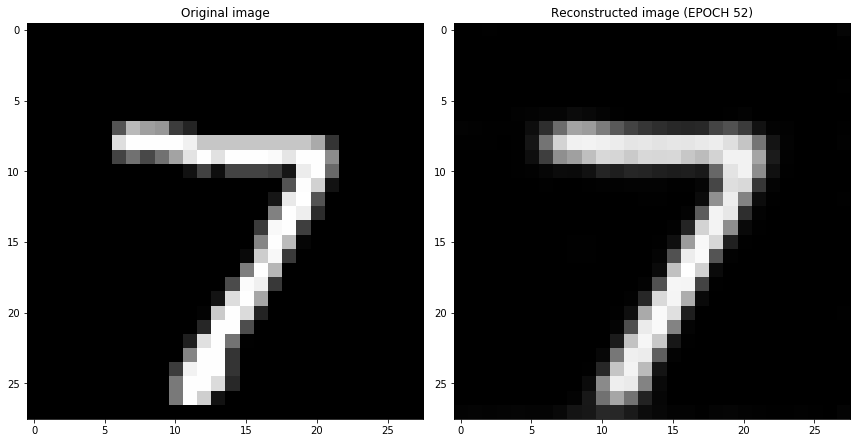

<Figure size 432x288 with 0 Axes>

EPOCH 53/100

	 TRAINING - EPOCH 53/100 - loss: 0.015445

	 VALIDATION - EPOCH 53/100 - loss: 0.015011




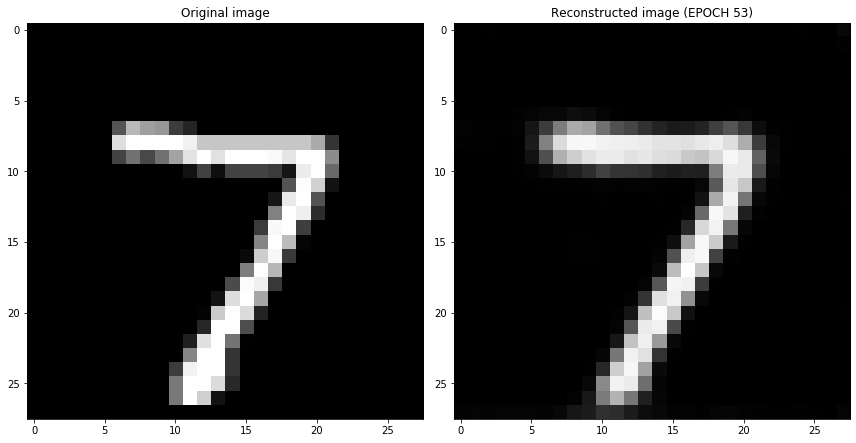

<Figure size 432x288 with 0 Axes>

EPOCH 54/100

	 TRAINING - EPOCH 54/100 - loss: 0.015509

	 VALIDATION - EPOCH 54/100 - loss: 0.015139




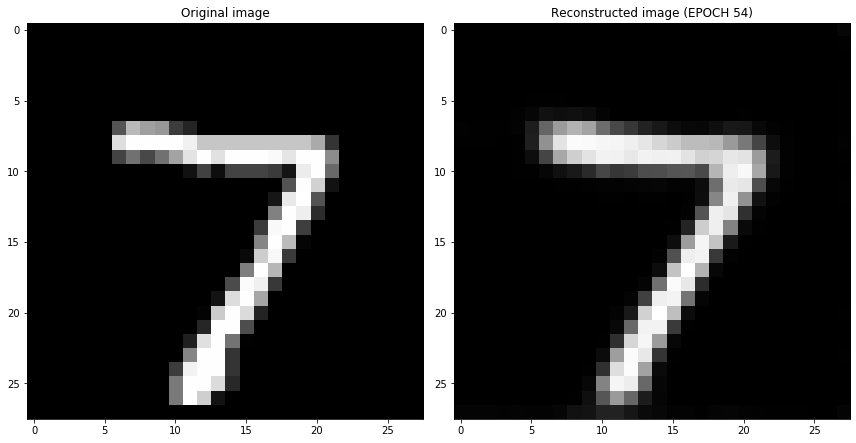

<Figure size 432x288 with 0 Axes>

EPOCH 55/100

	 TRAINING - EPOCH 55/100 - loss: 0.015455

	 VALIDATION - EPOCH 55/100 - loss: 0.015136




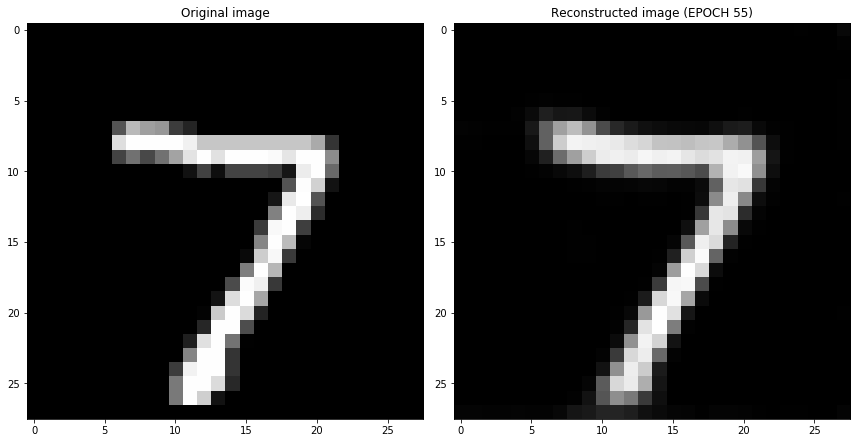

<Figure size 432x288 with 0 Axes>

EPOCH 56/100

	 TRAINING - EPOCH 56/100 - loss: 0.015393

	 VALIDATION - EPOCH 56/100 - loss: 0.015133




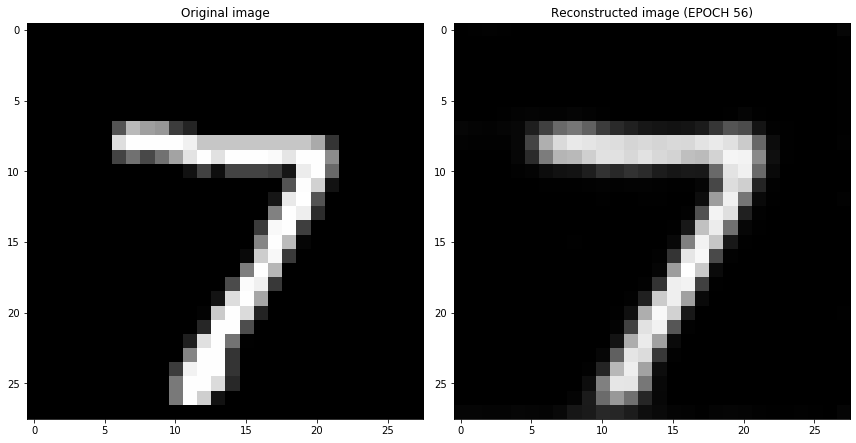

<Figure size 432x288 with 0 Axes>

EPOCH 57/100

	 TRAINING - EPOCH 57/100 - loss: 0.015405

	 VALIDATION - EPOCH 57/100 - loss: 0.016141




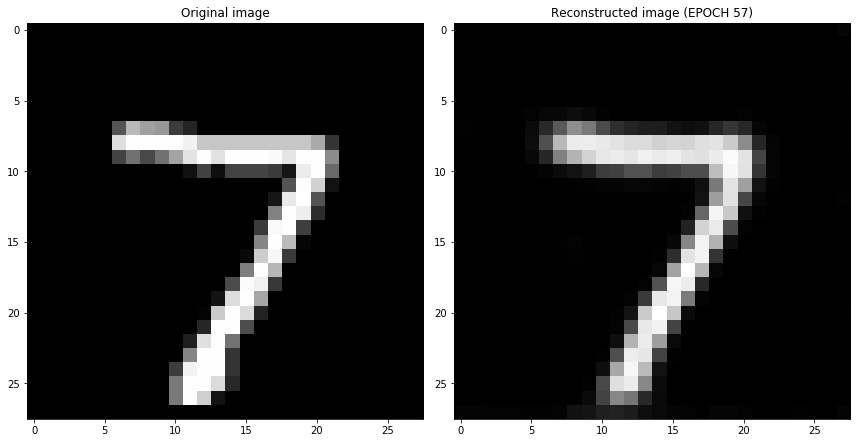

<Figure size 432x288 with 0 Axes>

EPOCH 58/100

	 TRAINING - EPOCH 58/100 - loss: 0.015413

	 VALIDATION - EPOCH 58/100 - loss: 0.015573




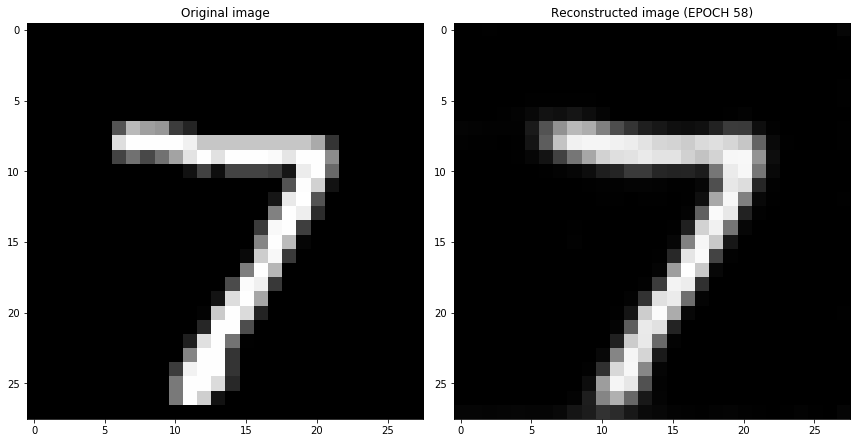

<Figure size 432x288 with 0 Axes>

EPOCH 59/100

	 TRAINING - EPOCH 59/100 - loss: 0.015366

	 VALIDATION - EPOCH 59/100 - loss: 0.015301




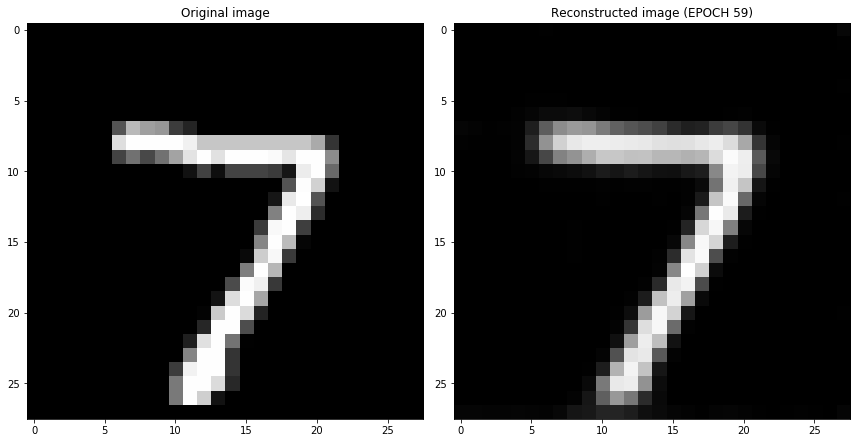

<Figure size 432x288 with 0 Axes>

EPOCH 60/100

	 TRAINING - EPOCH 60/100 - loss: 0.015298

	 VALIDATION - EPOCH 60/100 - loss: 0.015458




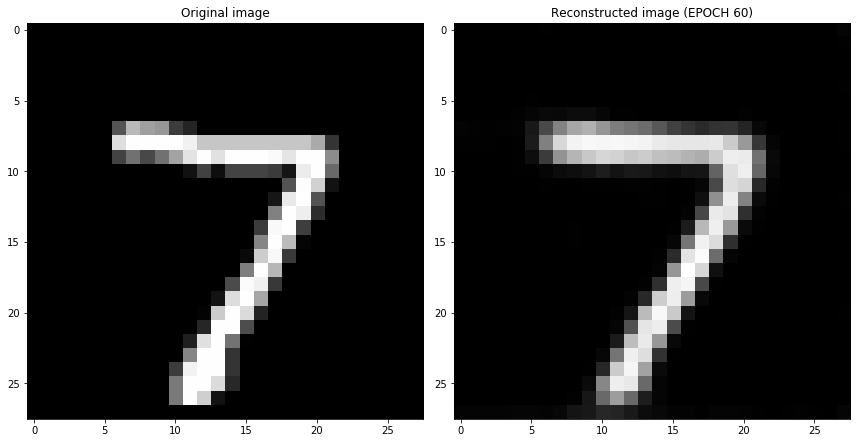

<Figure size 432x288 with 0 Axes>

EPOCH 61/100

	 TRAINING - EPOCH 61/100 - loss: 0.015419

	 VALIDATION - EPOCH 61/100 - loss: 0.015831




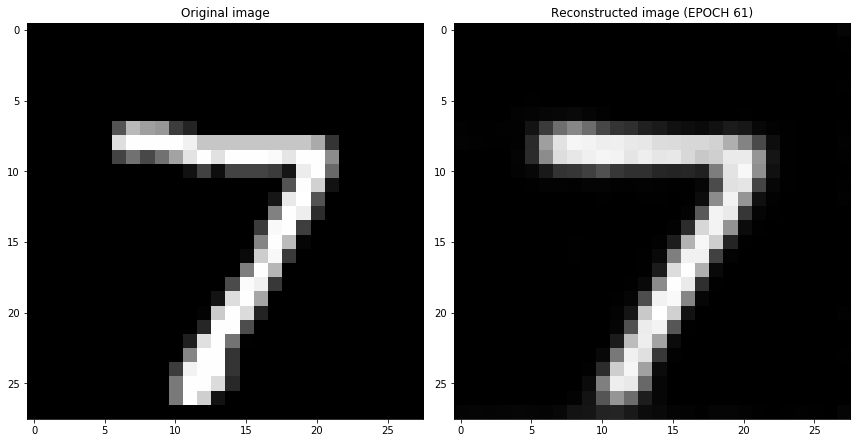

<Figure size 432x288 with 0 Axes>

EPOCH 62/100

	 TRAINING - EPOCH 62/100 - loss: 0.015400

	 VALIDATION - EPOCH 62/100 - loss: 0.015260




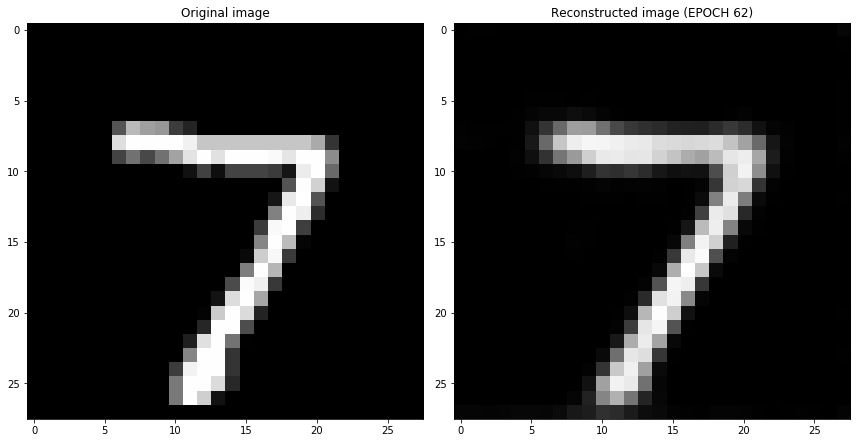

<Figure size 432x288 with 0 Axes>

EPOCH 63/100

	 TRAINING - EPOCH 63/100 - loss: 0.015346

	 VALIDATION - EPOCH 63/100 - loss: 0.015265




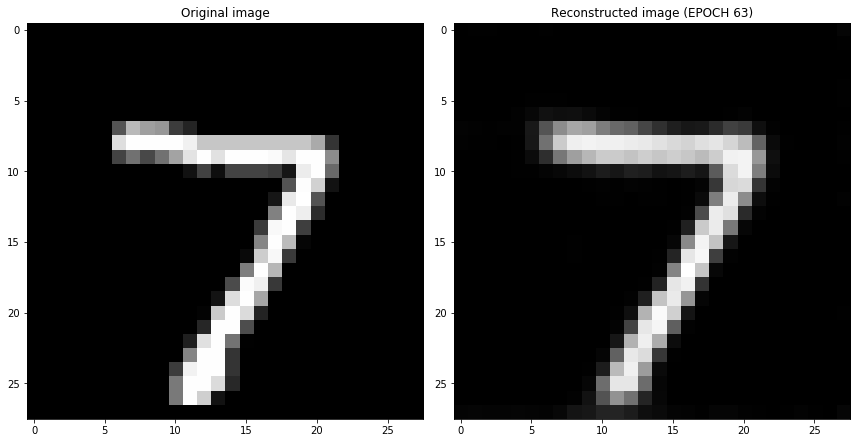

<Figure size 432x288 with 0 Axes>

EPOCH 64/100

	 TRAINING - EPOCH 64/100 - loss: 0.015437

	 VALIDATION - EPOCH 64/100 - loss: 0.015081




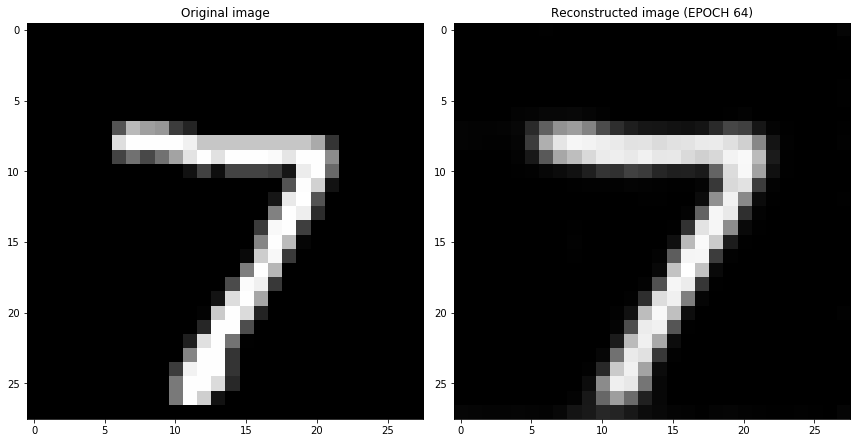

<Figure size 432x288 with 0 Axes>

EPOCH 65/100

	 TRAINING - EPOCH 65/100 - loss: 0.015377

	 VALIDATION - EPOCH 65/100 - loss: 0.015683




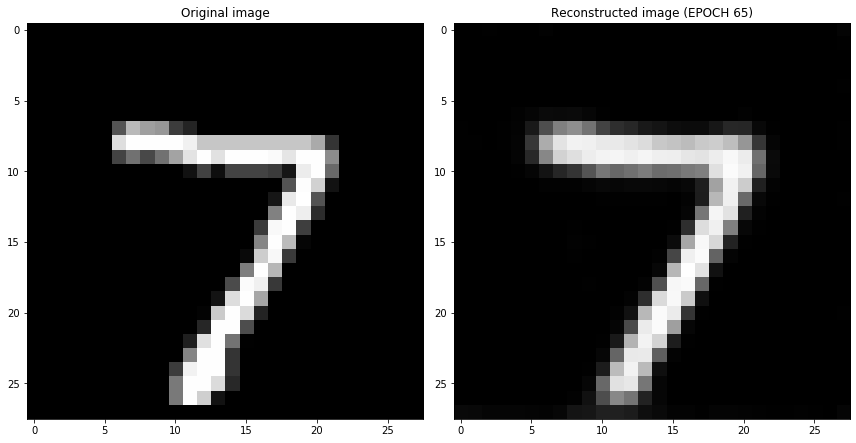

<Figure size 432x288 with 0 Axes>

EPOCH 66/100

	 TRAINING - EPOCH 66/100 - loss: 0.015413

	 VALIDATION - EPOCH 66/100 - loss: 0.015382




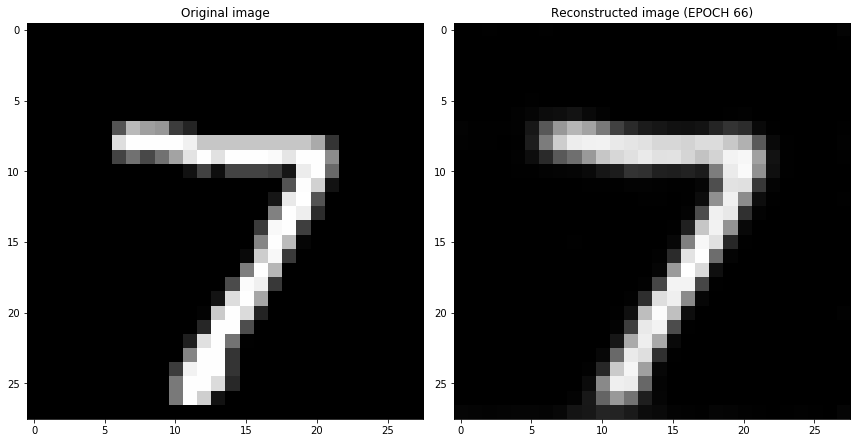

<Figure size 432x288 with 0 Axes>

EPOCH 67/100

	 TRAINING - EPOCH 67/100 - loss: 0.015274

	 VALIDATION - EPOCH 67/100 - loss: 0.015200




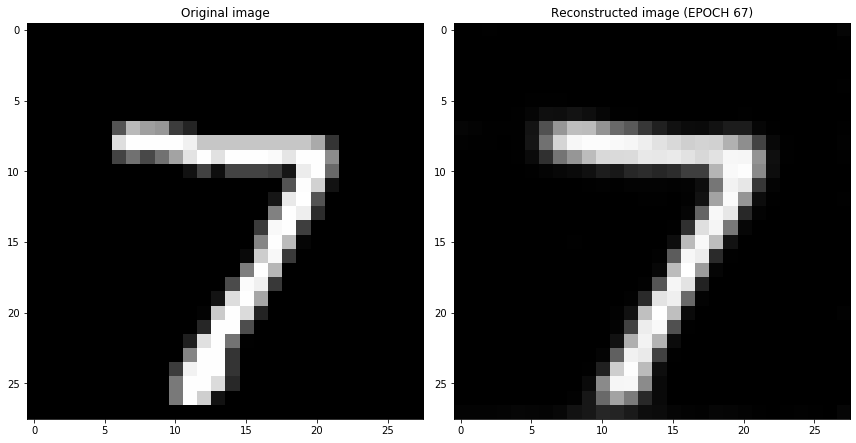

<Figure size 432x288 with 0 Axes>

EPOCH 68/100

	 TRAINING - EPOCH 68/100 - loss: 0.015270

	 VALIDATION - EPOCH 68/100 - loss: 0.015203




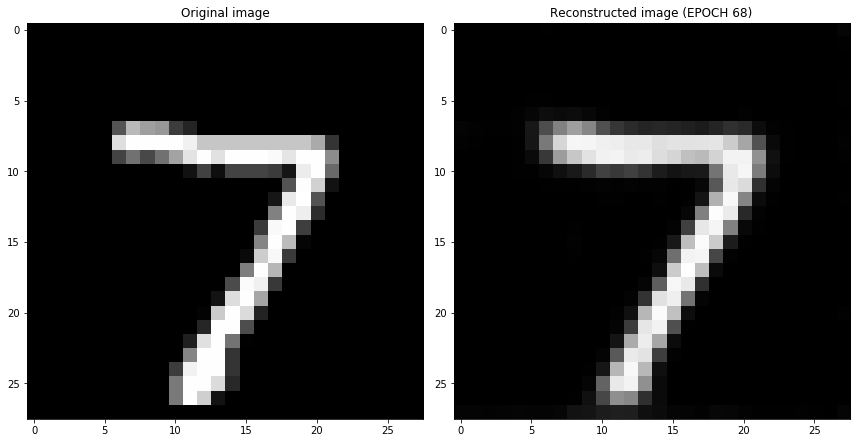

<Figure size 432x288 with 0 Axes>

EPOCH 69/100

	 TRAINING - EPOCH 69/100 - loss: 0.015441

	 VALIDATION - EPOCH 69/100 - loss: 0.015281




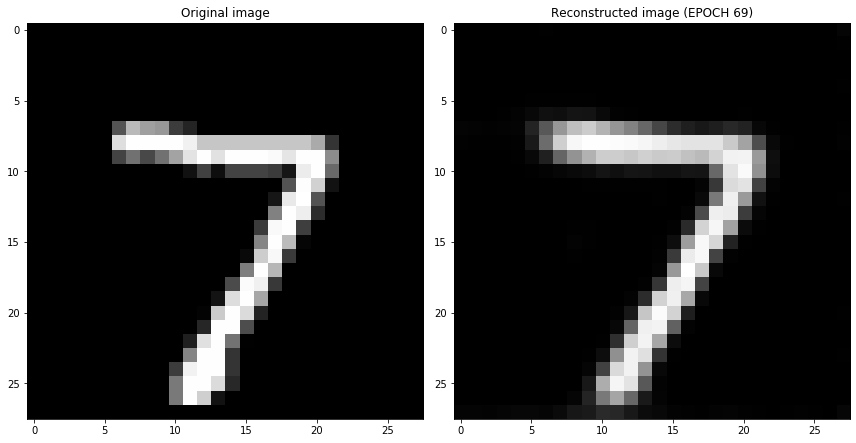

<Figure size 432x288 with 0 Axes>

EPOCH 70/100

	 TRAINING - EPOCH 70/100 - loss: 0.015290

	 VALIDATION - EPOCH 70/100 - loss: 0.015258




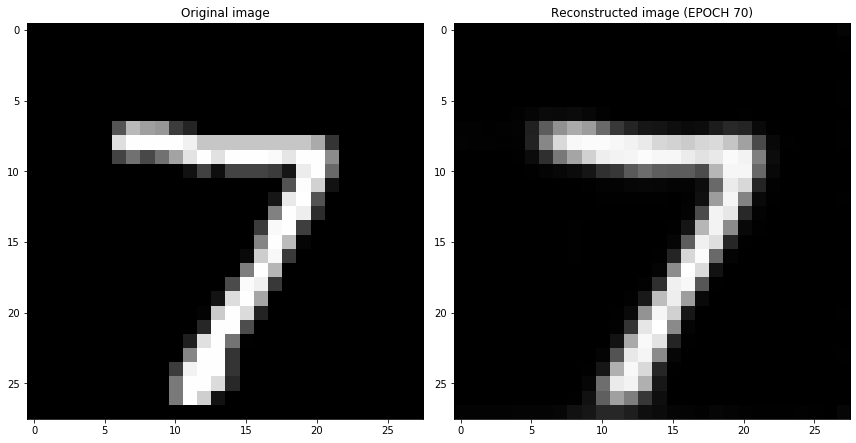

<Figure size 432x288 with 0 Axes>

EPOCH 71/100

	 TRAINING - EPOCH 71/100 - loss: 0.015158

	 VALIDATION - EPOCH 71/100 - loss: 0.015358




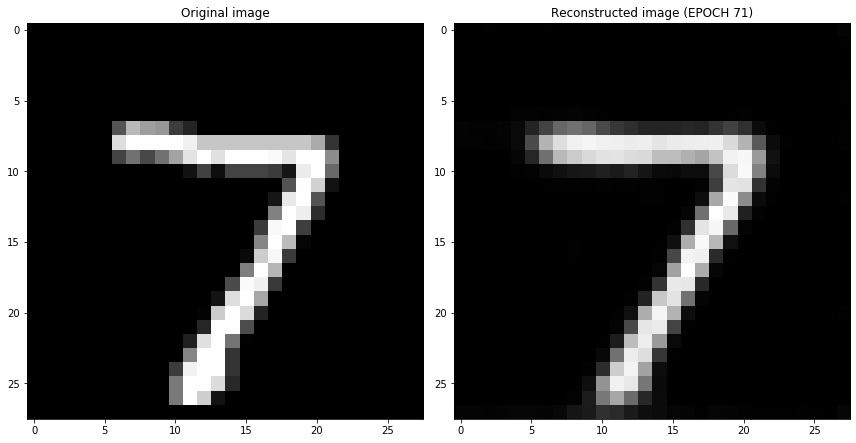

<Figure size 432x288 with 0 Axes>

EPOCH 72/100

	 TRAINING - EPOCH 72/100 - loss: 0.015422

	 VALIDATION - EPOCH 72/100 - loss: 0.015335




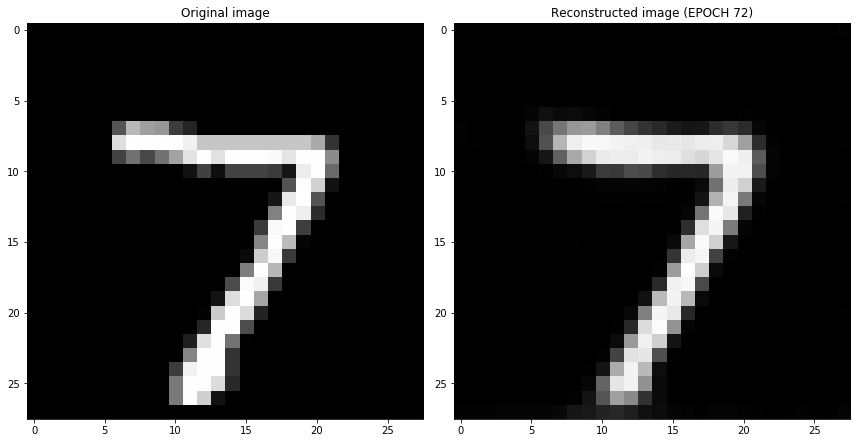

<Figure size 432x288 with 0 Axes>

EPOCH 73/100

	 TRAINING - EPOCH 73/100 - loss: 0.015359

	 VALIDATION - EPOCH 73/100 - loss: 0.015304




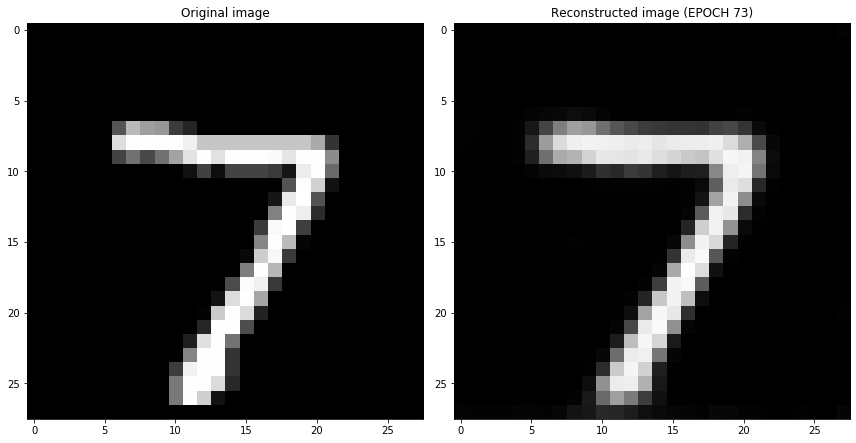

<Figure size 432x288 with 0 Axes>

EPOCH 74/100

	 TRAINING - EPOCH 74/100 - loss: 0.015404

	 VALIDATION - EPOCH 74/100 - loss: 0.014948




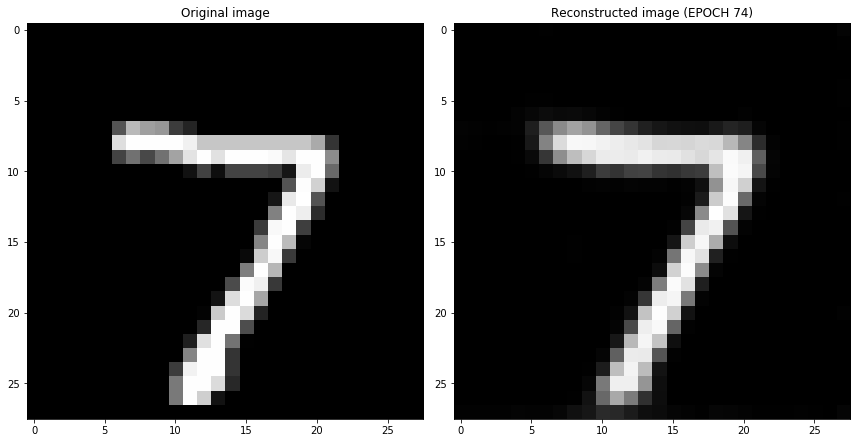

<Figure size 432x288 with 0 Axes>

EPOCH 75/100

	 TRAINING - EPOCH 75/100 - loss: 0.015179

	 VALIDATION - EPOCH 75/100 - loss: 0.015455




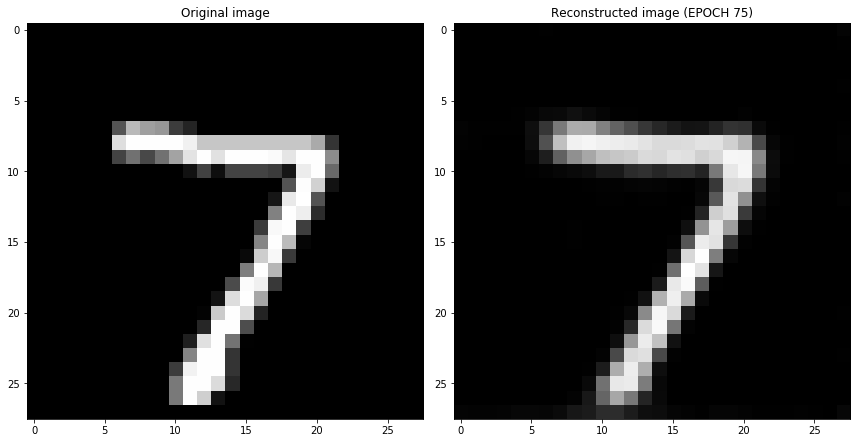

<Figure size 432x288 with 0 Axes>

EPOCH 76/100

	 TRAINING - EPOCH 76/100 - loss: 0.015310

	 VALIDATION - EPOCH 76/100 - loss: 0.016091




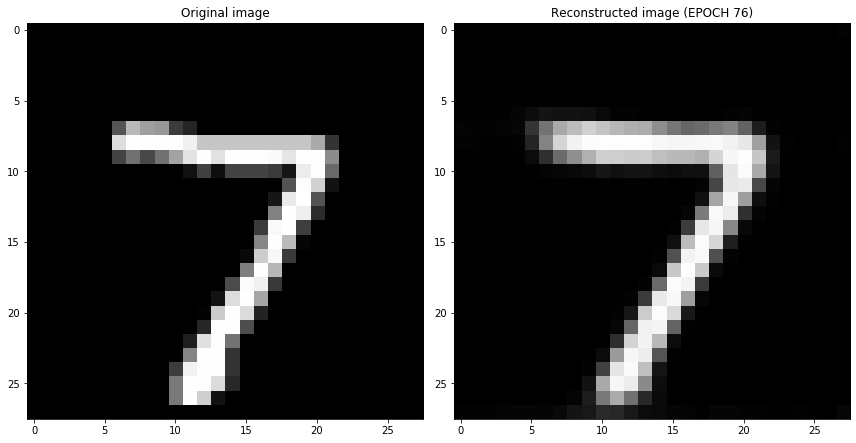

<Figure size 432x288 with 0 Axes>

EPOCH 77/100

	 TRAINING - EPOCH 77/100 - loss: 0.015363

	 VALIDATION - EPOCH 77/100 - loss: 0.015248




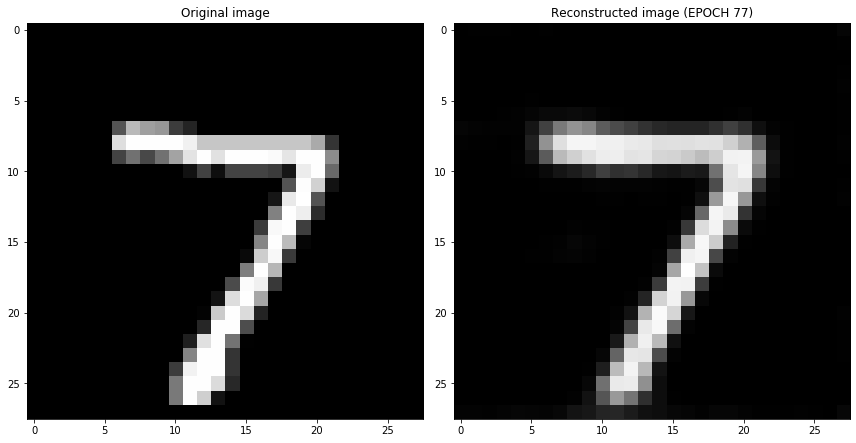

<Figure size 432x288 with 0 Axes>

EPOCH 78/100

	 TRAINING - EPOCH 78/100 - loss: 0.015194

	 VALIDATION - EPOCH 78/100 - loss: 0.015523




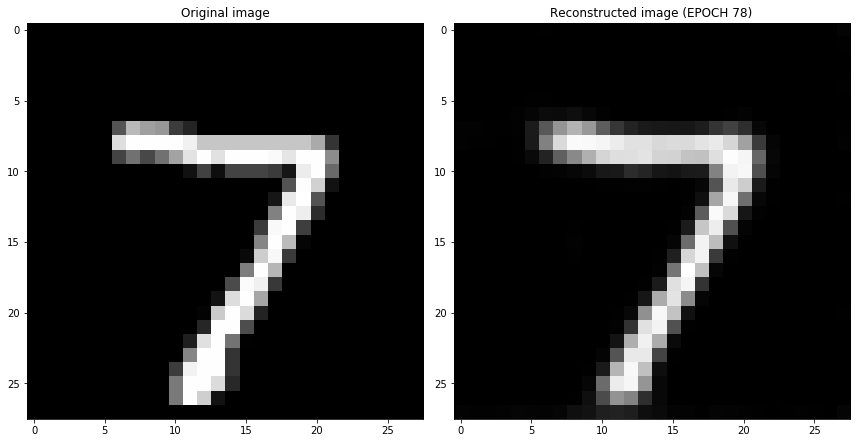

<Figure size 432x288 with 0 Axes>

EPOCH 79/100

	 TRAINING - EPOCH 79/100 - loss: 0.015438

	 VALIDATION - EPOCH 79/100 - loss: 0.015100




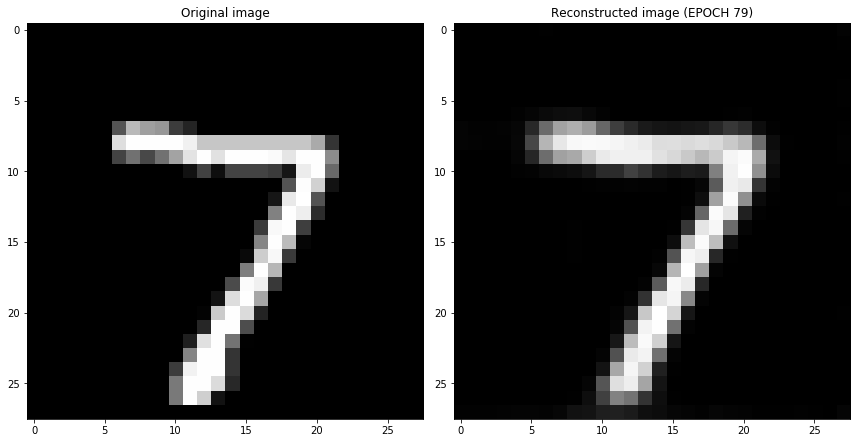

<Figure size 432x288 with 0 Axes>

EPOCH 80/100

	 TRAINING - EPOCH 80/100 - loss: 0.015166

	 VALIDATION - EPOCH 80/100 - loss: 0.015319




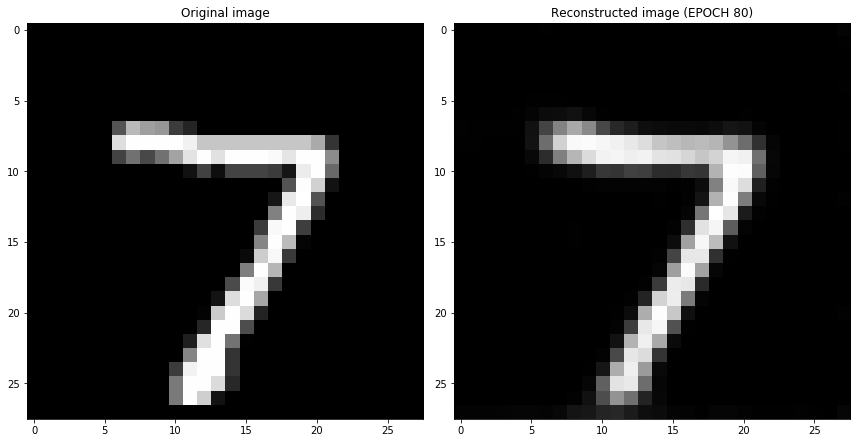

<Figure size 432x288 with 0 Axes>

EPOCH 81/100

	 TRAINING - EPOCH 81/100 - loss: 0.015296

	 VALIDATION - EPOCH 81/100 - loss: 0.015154




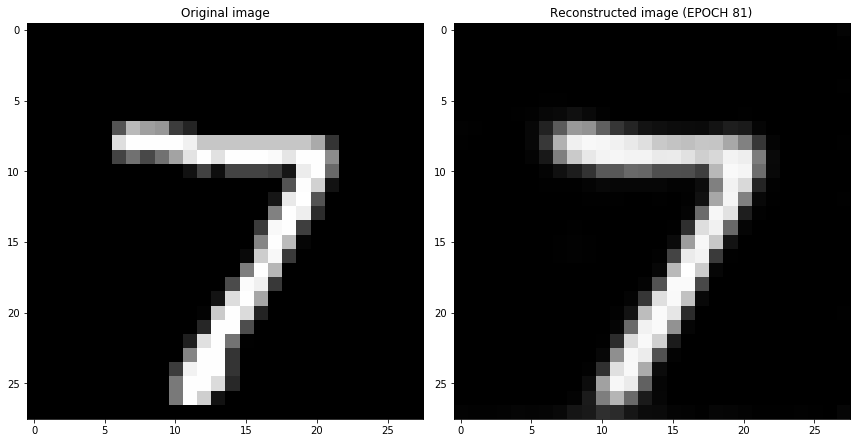

<Figure size 432x288 with 0 Axes>

EPOCH 82/100

	 TRAINING - EPOCH 82/100 - loss: 0.015262

	 VALIDATION - EPOCH 82/100 - loss: 0.015183




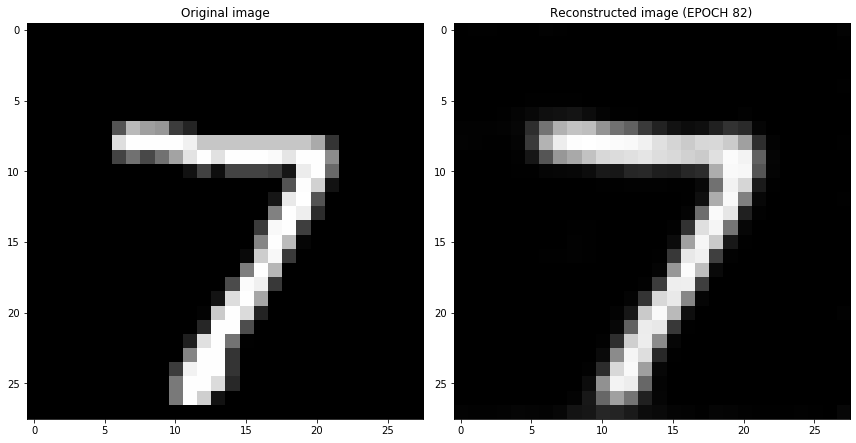

<Figure size 432x288 with 0 Axes>

EPOCH 83/100

	 TRAINING - EPOCH 83/100 - loss: 0.015266

	 VALIDATION - EPOCH 83/100 - loss: 0.014989




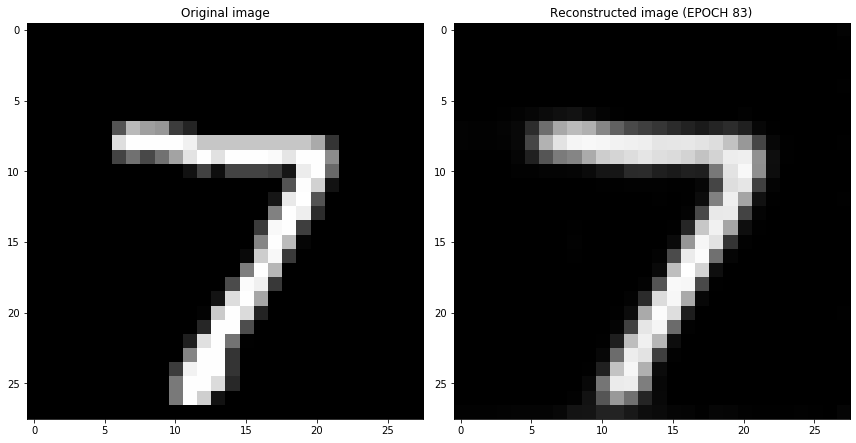

<Figure size 432x288 with 0 Axes>

EPOCH 84/100

	 TRAINING - EPOCH 84/100 - loss: 0.015211

	 VALIDATION - EPOCH 84/100 - loss: 0.015308




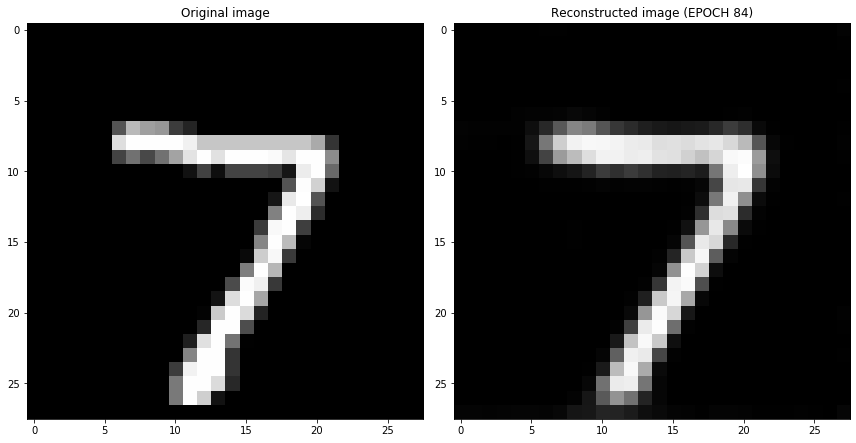

<Figure size 432x288 with 0 Axes>

EPOCH 85/100

	 TRAINING - EPOCH 85/100 - loss: 0.015229

	 VALIDATION - EPOCH 85/100 - loss: 0.015540




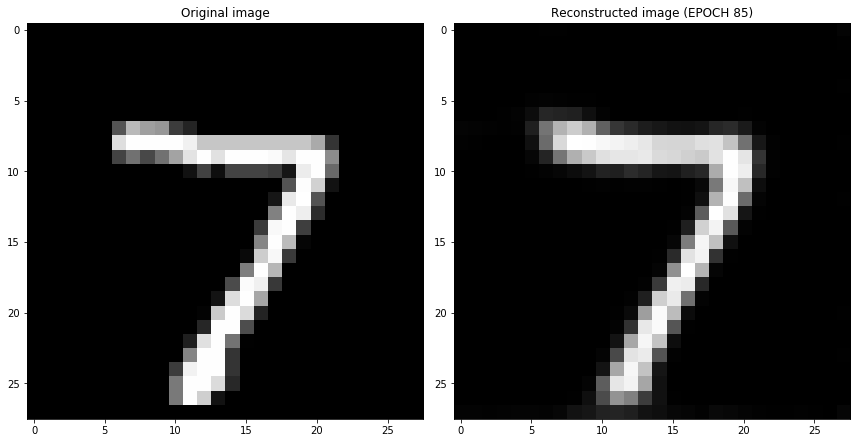

<Figure size 432x288 with 0 Axes>

EPOCH 86/100

	 TRAINING - EPOCH 86/100 - loss: 0.015477

	 VALIDATION - EPOCH 86/100 - loss: 0.016885




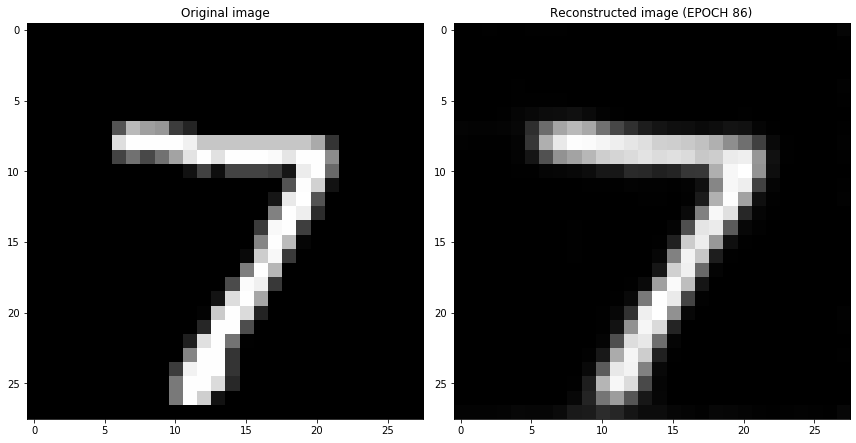

<Figure size 432x288 with 0 Axes>

EPOCH 87/100

	 TRAINING - EPOCH 87/100 - loss: 0.015317

	 VALIDATION - EPOCH 87/100 - loss: 0.015039




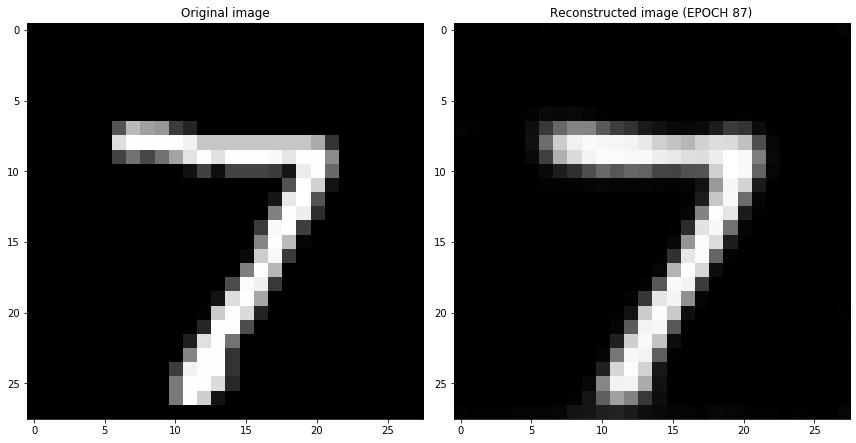

<Figure size 432x288 with 0 Axes>

EPOCH 88/100

	 TRAINING - EPOCH 88/100 - loss: 0.015211

	 VALIDATION - EPOCH 88/100 - loss: 0.014990




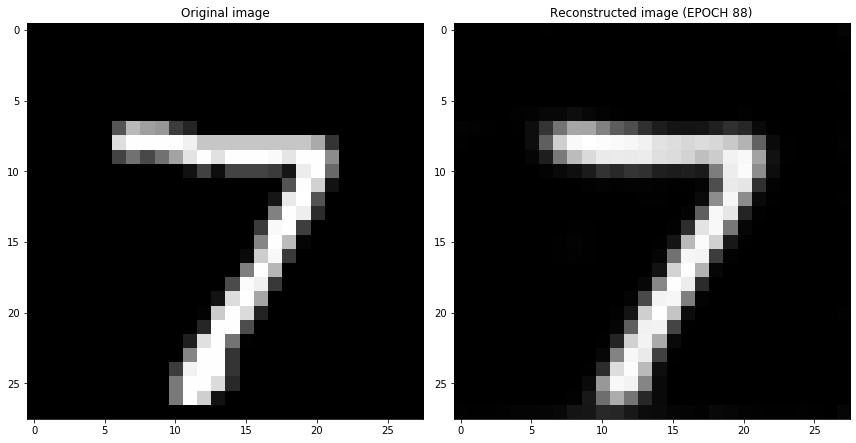

<Figure size 432x288 with 0 Axes>

EPOCH 89/100

	 TRAINING - EPOCH 89/100 - loss: 0.015206

	 VALIDATION - EPOCH 89/100 - loss: 0.015708




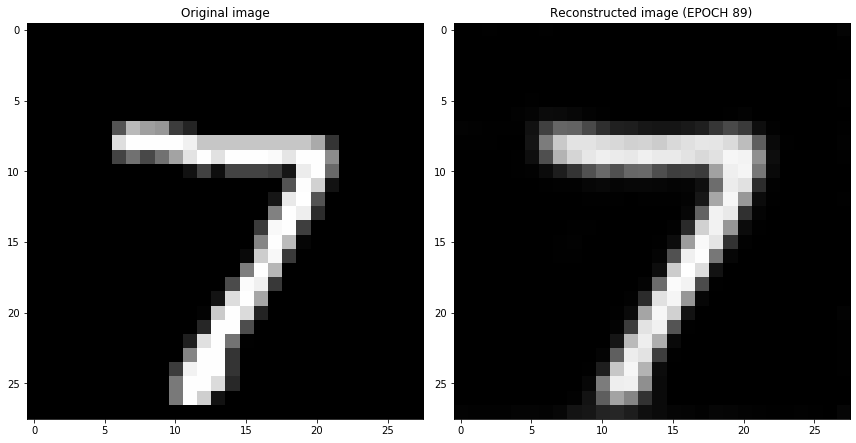

<Figure size 432x288 with 0 Axes>

EPOCH 90/100

	 TRAINING - EPOCH 90/100 - loss: 0.015310

	 VALIDATION - EPOCH 90/100 - loss: 0.015135




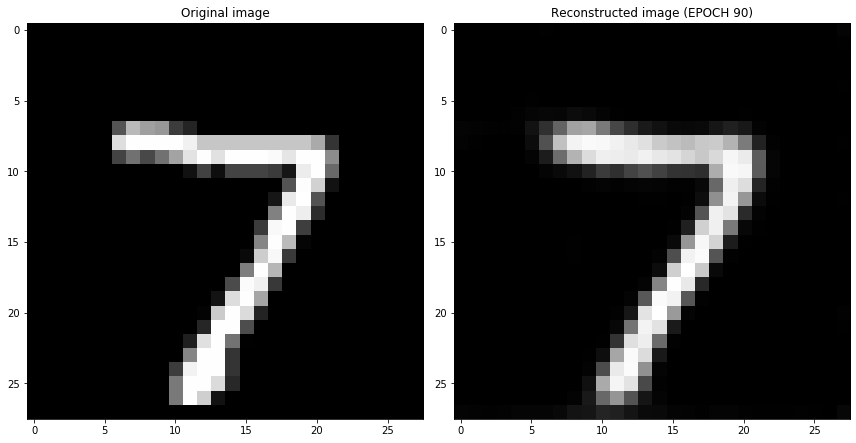

<Figure size 432x288 with 0 Axes>

EPOCH 91/100

	 TRAINING - EPOCH 91/100 - loss: 0.015192

	 VALIDATION - EPOCH 91/100 - loss: 0.015373




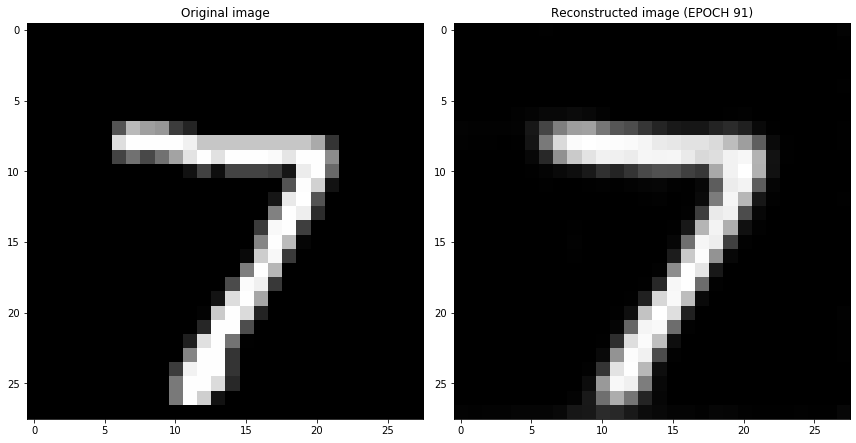

<Figure size 432x288 with 0 Axes>

EPOCH 92/100

	 TRAINING - EPOCH 92/100 - loss: 0.015272

	 VALIDATION - EPOCH 92/100 - loss: 0.015761




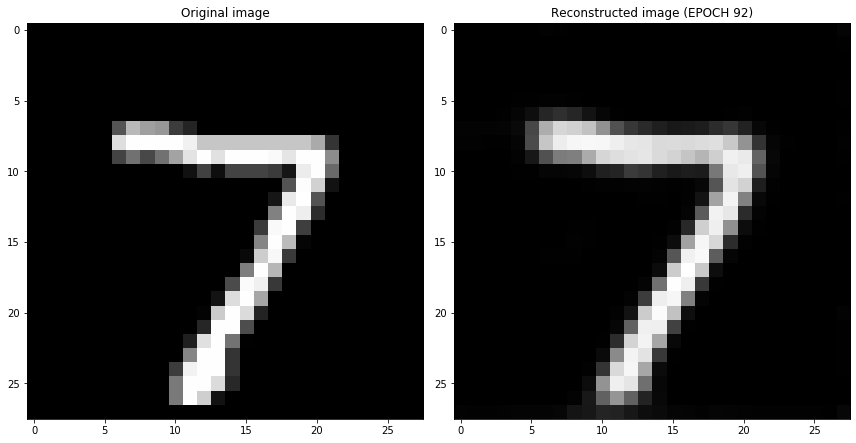

<Figure size 432x288 with 0 Axes>

EPOCH 93/100

	 TRAINING - EPOCH 93/100 - loss: 0.015223

	 VALIDATION - EPOCH 93/100 - loss: 0.015005




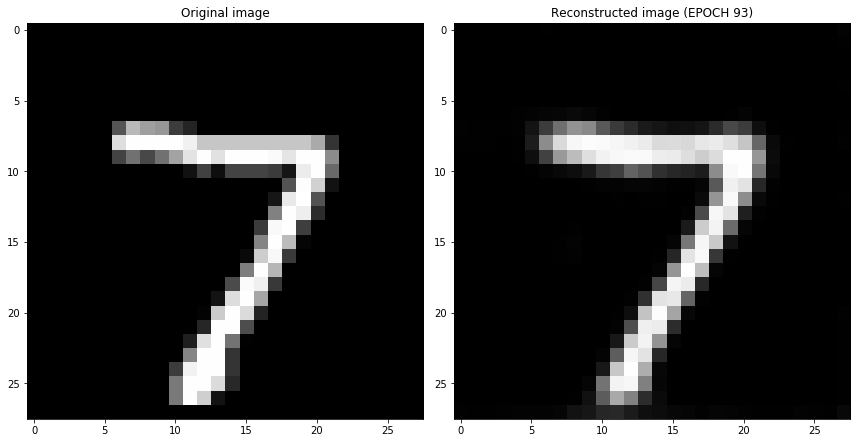

<Figure size 432x288 with 0 Axes>

EPOCH 94/100

	 TRAINING - EPOCH 94/100 - loss: 0.015468

	 VALIDATION - EPOCH 94/100 - loss: 0.015794




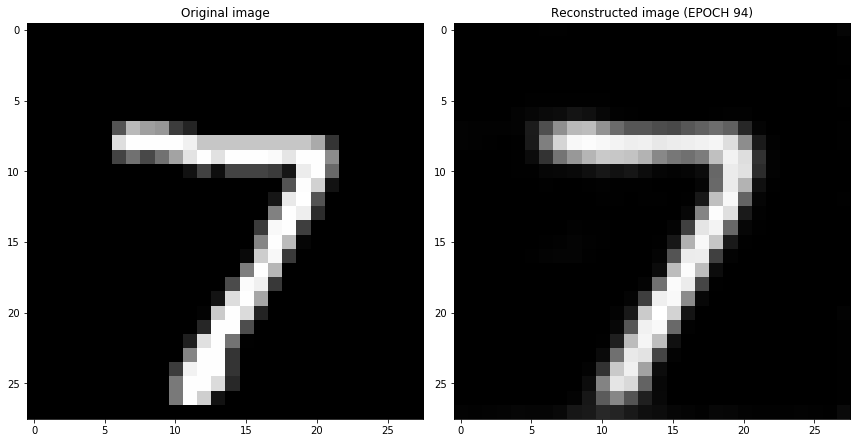

<Figure size 432x288 with 0 Axes>

EPOCH 95/100

	 TRAINING - EPOCH 95/100 - loss: 0.015146

	 VALIDATION - EPOCH 95/100 - loss: 0.015008




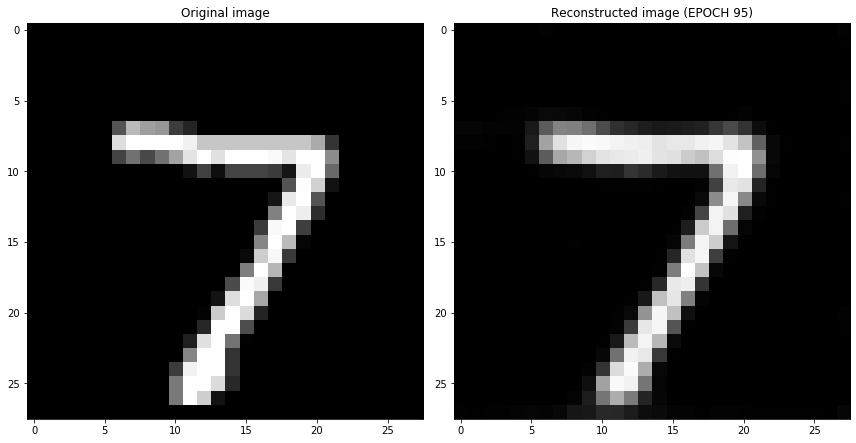

<Figure size 432x288 with 0 Axes>

EPOCH 96/100

	 TRAINING - EPOCH 96/100 - loss: 0.015236

	 VALIDATION - EPOCH 96/100 - loss: 0.015259




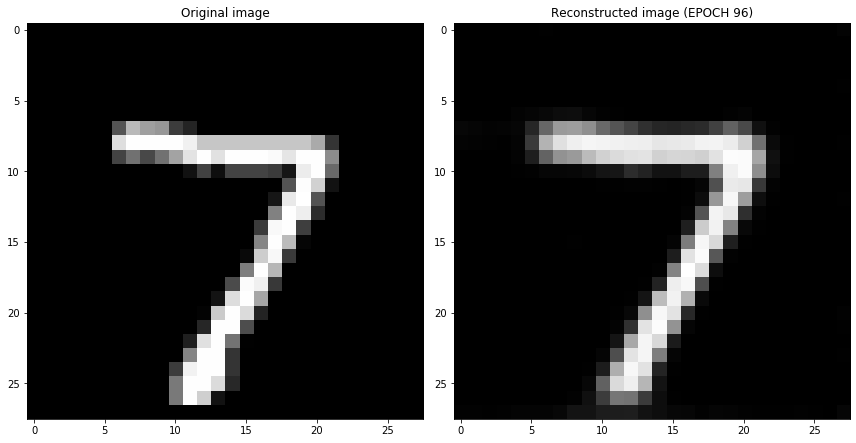

<Figure size 432x288 with 0 Axes>

EPOCH 97/100

	 TRAINING - EPOCH 97/100 - loss: 0.015270

	 VALIDATION - EPOCH 97/100 - loss: 0.015136




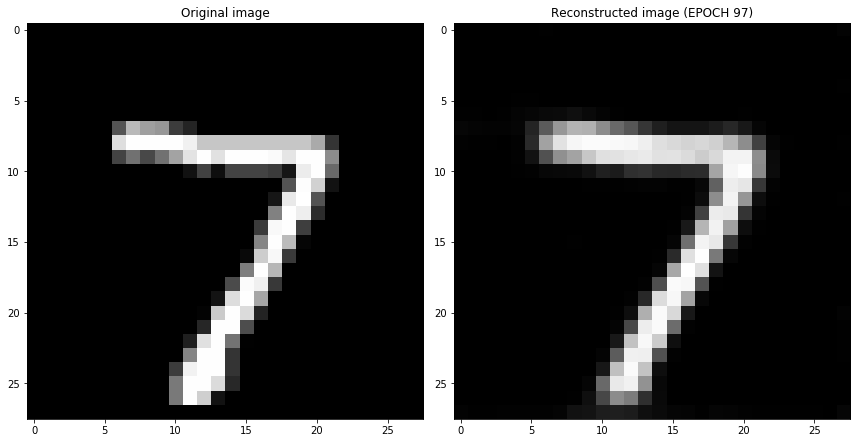

<Figure size 432x288 with 0 Axes>

EPOCH 98/100

	 TRAINING - EPOCH 98/100 - loss: 0.015062

	 VALIDATION - EPOCH 98/100 - loss: 0.015031




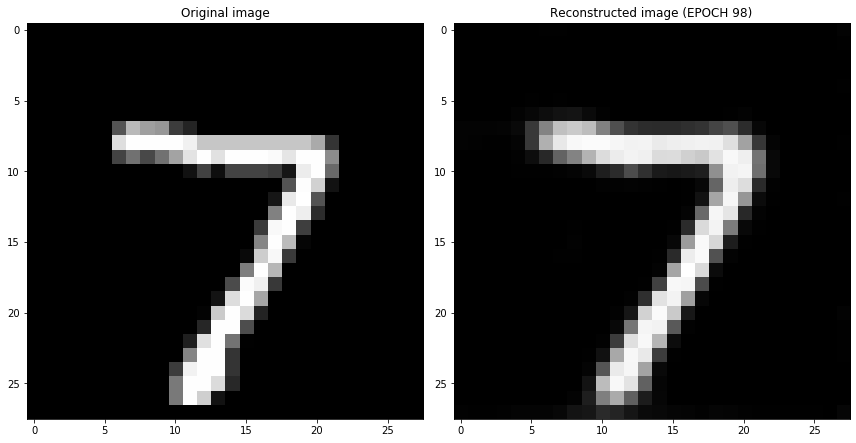

<Figure size 432x288 with 0 Axes>

EPOCH 99/100

	 TRAINING - EPOCH 99/100 - loss: 0.015525

	 VALIDATION - EPOCH 99/100 - loss: 0.015607




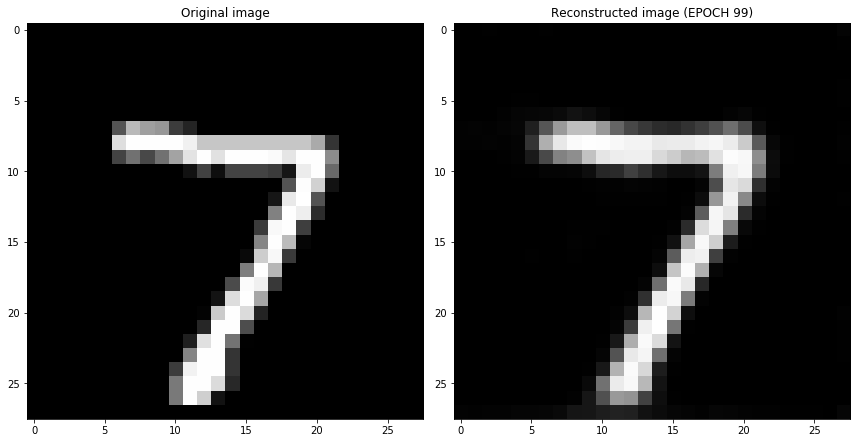

<Figure size 432x288 with 0 Axes>

EPOCH 100/100

	 TRAINING - EPOCH 100/100 - loss: 0.015136

	 VALIDATION - EPOCH 100/100 - loss: 0.014897




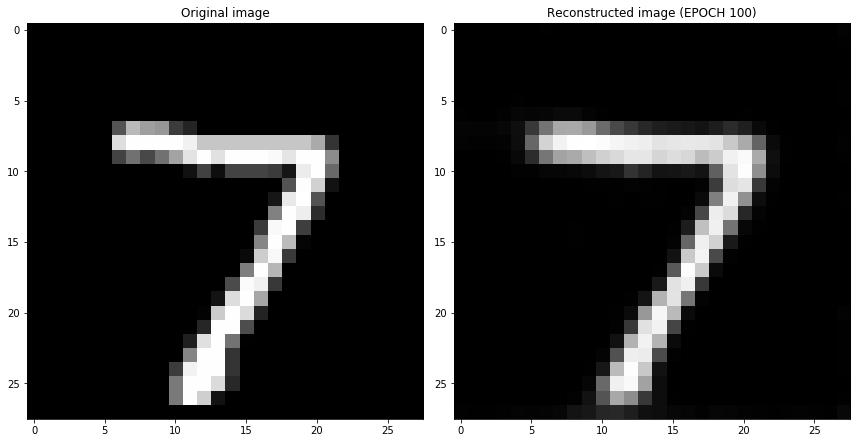

<Figure size 432x288 with 0 Axes>

CPU times: user 1h 57min 45s, sys: 24.5 s, total: 1h 58min 9s
Wall time: 1h 27min 35s


In [39]:
%%time

### ADD EARLY STOPPING?

# Set dimension of interest
encoded_space_dim = 4
# Set number of epochs
num_epochs = 100
# Set parameters
lr = 1e-2
decay = 1e-5
# Define an optimizer
optim = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=decay)

train_loss_log = []
val_loss_log = []

### Training cycle
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training
    train_loss = train_epoch(net, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optim, device=device) 
    print('\n\t TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, train_loss))
    ### Validation
    val_loss = test_epoch(net, dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optim, device=device) 
    # Print Validation
    print('\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    img = test_dataset[0][0].unsqueeze(0).to(device)
    net.eval()
    with torch.no_grad():
        rec_img  = net(img)
    fig, axs = plt.subplots(1, 2, figsize=(12,6))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('./images/autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    plt.savefig('./images/autoencoder_progress_%d_features/epoch_%d.png' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(net.state_dict(), f'./results/net_params_{encoded_space_dim}.pth')

    train_loss_log.append(train_loss)
    val_loss_log.append(val_loss)

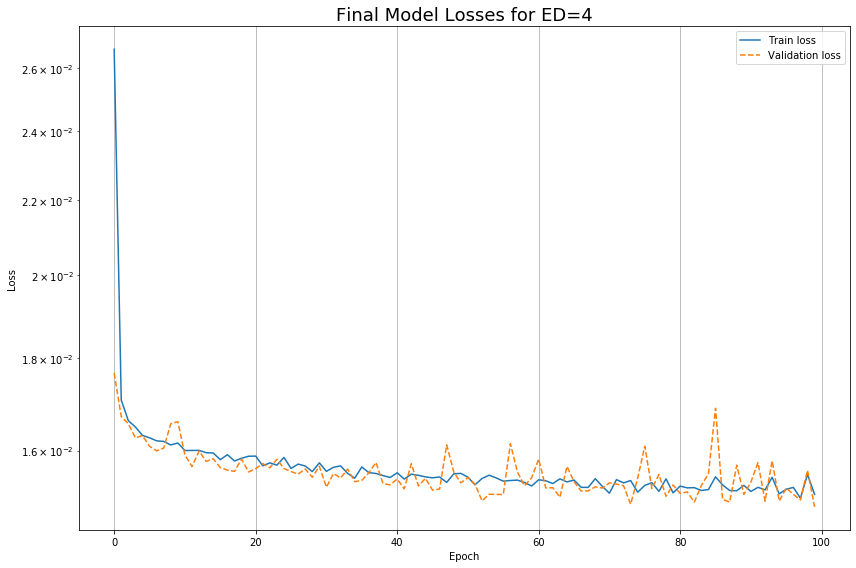

In [40]:
# Plot losses
plt.close('all')
plt.figure(figsize=(12,8))

plt.semilogy(train_loss_log, 
                label='Train loss')
plt.semilogy(val_loss_log, 
                label='Validation loss',
                linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.title(f'Final Model Losses for ED={encoded_space_dim}', fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(f"images/model_losses_{encoded_space_dim}.png")
plt.show()